# Предсказание успешности стартапа

**Цель и задачи:** разработать модель для предсказания успешности стартапа (закроется или нет).

**План проекта**
1. [Загрузка и ознакомление с данными](#1)

    1. [Вывод](#11)

2. [Предобработка данных](#2)
    
    1. [Столбцы со временем](#21)
    
    2. [Работа с дубликатами](#22)
    
    3. [Исследование уникальных значений](#23)
    
    4. [Укрупнение по материкам](#24)
    
    5. [Укрупнение категорий стартапов](#25)
    
    6. [Выводы](#26)

3. [Исследовательский анализ данных](#3)
    
    1. [Одномерный анализ](#31)
    
    2. [Двумерный анализ](#32)
    
    3. [Выводы](#33)

4. [Обучение модели и предсказание статуса стартапа](#4)
   
    1. [Обучение модели](#41)
    
    2. [Предсказание модели для тестовой выборки](#42)
    
    3. [Вывод](#43)
5. [Анализ важности признаков](#5)
6. [Итоговый вывод](#6)

**Описание данных**
Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак `status`, указывающий на то, закрылся стартап или продолжает действовать. Временной период - `'1970-01-01'` по `'2018-01-01'`. Дата формирования выгрузки - `'2018-01-01'`.

- `kaggle_startups_train_01.csv` - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- `kaggle_startups_test_01.csv` - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
- `name` - идентификатор (название) стартапа в тестовом наборе.
- `status` - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу `['operating', 'closed']`.

**Описание полей данных**
- `name` - Название стартапа;
- `category_list` - Список категорий, к которым относится стартап;
- `funding_total_usd` - Общая сумма финансирования в USD;
- `status` - Статус стартапа (закрыт или действующий);
- `country_code` - Код страны;
- `state_code` - Код штата;
- `region` - Регион;
- `city` - Город;
- `funding_rounds` - Количество раундов финансирования;
- `founded_at` - Дата основания;
- `first_funding_at` - Дата первого раунда финансирования;
- `last_funding_at` - Дата последнего раунда финансирования;
- `closed_at` - Дата закрытия стартапа (если применимо);
- `lifetime` - Время существования стартапа в днях.

In [ ]:
!pip install phik -q

In [ ]:
!pip install pycountry -q

In [ ]:
!pip install pycountry_convert -q

In [ ]:
!pip install geopandas plotly -q

In [ ]:
!pip install geonamescache -q

In [ ]:
!pip install catboost -q

In [ ]:
!pip install optuna -q

In [201]:
import os
import webbrowser
import time
import pickle
import re

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import geopandas as gpd
import phik
from phik.report import plot_correlation_matrix
from phik import report
from shapely.geometry import Point

from scipy.stats import shapiro, ttest_ind, chi2_contingency
# для гео данных
import pycountry
import pycountry_convert as pc
from urllib.request import Request
from geopy.geocoders import Nominatim

#для категорий стартапов
from collections import Counter
from itertools import chain

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score  
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import shap

In [202]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
%matplotlib inline

In [203]:
TEST_SIZE = .25
RANDOM_STATE = 42

## Загрузка и ознакомление с данными <a id='1'></a>

Загружу тестовый и тренировачный датасет, также проверим лежат ли они в нужной директории. Если нет, то нужно будет проверить корректность расположения. У меня датасеты лежат в одной папке с тетрадкой.

In [204]:
pth1 = 'kaggle_startups_train_27042024.csv'
pth2 = 'kaggle_startups_test_27042024.csv'
    
    
if (os.path.exists(pth1)) and (os.path.exists(pth2)):
    train = pd.read_csv(pth1)
    test = pd.read_csv(pth2)
else:
    print('Error Data path')

Ошибки нет. Файлы лежат где нужно. Напишу функцию, которая выведет общую информацию о тренровочном и тестовом датасете.

In [205]:
def info_df(data):
    display(data.info())
    display(data.describe())
    display(data.head(10))

In [206]:
info_df(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

funding_total_usd  funding_rounds
count         42445.0000      52514.0000
mean       18248255.9797          1.7407
std       187121675.7097          1.3745
min               1.0000          1.0000
25%          336000.0000          1.0000
50%         2000000.0000          1.0000
75%        10000000.0000          2.0000
max     30079503000.0000         19.0000

name  \
0                  Lunchgate   
1                    EarLens   
2     Reviva Pharmaceuticals   
3       Sancilio and Company   
4        WireTough Cylinders   
5  Connected Sports Ventures   
6                  Attensity   
7              Mesh Networks   
8                 AngioScore   
9                 Vidatronic   

                                       category_list  funding_total_usd  \
0                    Online Reservations|Restaurants        828626.0000   
1              Manufacturing|Medical|Medical Devices      42935019.0000   
2                                      Biotechnology      35456381.0000   
3                                        Health Care      22250000.0000   
4                                      Manufacturing                NaN   
5                                             Mobile       4300000.0000   
6  Analytics|Business Analytics|Social CRM|Social...      90000000.0000   
7                                           Software       4300000.0000   
8                                      Biotechnology      42000000.0000   
9                                     Semiconductors       1250500.0000   

      status country_code state_code       region             city  \
0  operating          CHE         25       Zurich           Zürich   
1  operating          USA         CA  SF Bay Area     Redwood City   
2  operating          USA         CA  SF Bay Area         San Jose   
3  operating          NaN        NaN          NaN              NaN   
4  operating          USA         VA   VA - Other          Bristol   
5  operating          USA         NJ       Newark        Princeton   
6  operating          USA         CA  SF Bay Area     Redwood City   
7  operating          USA         TX      Houston          Houston   
8  operating          USA         CA  SF Bay Area          Fremont   
9  operating          USA         TX       Austin  College Station   

   funding_rounds  founded_at first_funding_at last_funding_at closed_at  
0               2  2009-12-31       2011-05-01      2014-12-01       NaN  
1               4  2005-01-01       2010-05-04      2014-02-25       NaN  
2               3  2006-01-01       2012-08-20      2014-07-02       NaN  
3               3  2004-01-01       2011-09-01      2014-07-18       NaN  
4               1  2010-09-30       2012-02-01      2012-02-01       NaN  
5               1  2011-01-20       2012-11-12      2012-11-12       NaN  
6               1  2000-01-01       2014-05-14      2014-05-14       NaN  
7               1  2005-01-01       2014-11-09      2014-11-09       NaN  
8               2  2003-01-01       2007-10-09      2011-04-20       NaN  
9               2  2010-01-01       2011-08-23      2013-03-21       NaN

In [207]:
info_df(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   founded_at         13125 non-null  object 
 9   first_funding_at   13125 non-null  object 
 10  last_funding_at    13125 non-null  object 
 11  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


None

funding_total_usd  funding_rounds   lifetime
count         10547.0000      13125.0000 13125.0000
mean       16549102.6951          1.7144  3098.2056
std        92172825.6318          1.3188  2128.4888
min               1.0000          1.0000    79.0000
25%          320000.0000          1.0000  1729.0000
50%         2000000.0000          1.0000  2526.0000
75%        10000000.0000          2.0000  3871.0000
max      4715000000.0000         15.0000 17167.0000

name                     category_list  \
0              Crystalsol                  Clean Technology   
1        JBI Fish & Wings                       Hospitality   
2                COINPLUS                           Finance   
3  Imagine Communications    Software|Video|Video Streaming   
4                   DNA13                          Software   
5         Quickfire Games        Design|Entertainment|Games   
6              Sente Inc.                     Biotechnology   
7                 Triosyn  Health Care|Medical|Therapeutics   
8               Urgent.ly                          Software   
9           Map Decisions                          Software   

   funding_total_usd country_code state_code            region  \
0       2819200.0000          NIC         17               NaN   
1                NaN          USA         TN        TN - Other   
2        428257.0000          LUX          3  Esch-sur-alzette   
3      34700000.0000          USA         CA         San Diego   
4       4530000.0000          CAN         ON            Ottawa   
5        160000.0000          NaN        NaN               NaN   
6      26842000.0000          USA         CA         San Diego   
7       4000000.0000          NaN        NaN               NaN   
8       8710000.0000          USA         VA  Washington, D.C.   
9         13200.0000          USA         PA         Allentown   

               city  funding_rounds  founded_at first_funding_at  \
0               NaN               1  2008-06-01       2009-07-01   
1          Humboldt               1  2010-07-25       2010-07-28   
2  Esch-sur-alzette               2  2014-06-16       2014-05-15   
3         San Diego               4  2005-01-01       2005-01-01   
4            Ottawa               1  2001-01-01       2007-05-08   
5               NaN               2  2013-09-01       2013-09-18   
6         Encinitas               5  2007-01-01       2009-01-31   
7               NaN               1  2002-07-22       2003-06-02   
8          Sterling               3  2013-01-01       2014-04-17   
9         Bethlehem               1  2012-05-15       2013-08-09   

  last_funding_at  lifetime  
0      2009-07-01      3501  
1      2010-07-28      2717  
2      2014-09-18      1295  
3      2010-04-20      4748  
4      2007-05-08      6209  
5      2014-09-18      1583  
6      2014-06-02      4018  
7      2003-06-02      5642  
8      2015-09-29      1826  
9      2013-08-09      2057

### Вывод  <a id='11'></a>

Датасет `train` содержит 52514 записей. Пропуски присутствуют в `name` (52513 записей),  `category_list` (50049 записей), `funding_total_usd` (42445 записей), `country_code` (47013 записей), `state_code` (45752 записей), `region` (46156 записей), `city` (46156 записей)- последние 2 столбца содержат одинаковое количество пропусков. Далее вижу, что опистельная статистика показывает минимальную сумму инвестирования стоставляет 1 $, что не очень выглядит правдоподобным, максимальная сумма также вызывает некоторые вопросы. Что касется самих данных стилистически названия столбцов выглядт верно. `category_list` содержит записи категорий, причем они состоят не только из основной категории, но и мультикатегорийных данных. `state_code` - состоит из числовых и буквенных обозначений (или состая из того и другого, например, GBR - C7), причем буквенные характерны только для США. Также в датасете есть столбцы с датами, приведем их в формат `datetime`. В тренировочном датасете отустствует `lifetime`, чтобы его добавить найду разницу между `founded_at` и `closed_at`, при этом в последнем столбце есть пропуски заменим их датой выгрузки датасета `2018-01-01`.
Аналогична ситуация и для датасета `test`. Пропуски присутствуют в анлогичных столбцах, что и в `train`.

Какой по итогу план для следующего шага предобработки данных у меня сложился?
1. Изменить формат соответсвющих столбцов на `to_datetime`. Пропуски в `closed_at` в тренировочной заполню датой выгрузки.
2. Нужно проверить на наличие дубликатов.
3. Посмотреть уникальные значения для всех категориальных признаков. 
4. Не просто удалить, заполнить или etc пропуски, а понять природу их появления, какая между ними связь.
5. Сгруппировать страны по материкам
6. Укрупнить категории стартапов.

## Предварительная обработка <a id='2'></a>

Передам переменым первоначальную длину train и test.

In [208]:
train_shape = train.shape[0]
test_shape = test.shape[0]

### Столбцы со временем <a id='21'></a>

Приведу столбцы `founded_at`, `first_funding_at`, `last_funding_at`, `closed_at` в формат `to_datetime`. Далее заполню пропуски closed_at в тренировочном датасете. Добавлю столбец в тренировочный датасет время существования стартапа в днях (`lifetime`) и удалю `closed_at`, т.к. далее он не понадобится. Для этого создам класс, который будет выполнять все шаги.

Думаю, что можно выделить признаки: количество дней до финансированя стартапа и сколько дней финанировался стартап. Стоит также учитывать, что некторые стартапы получали финансирование до даты основания в датасете. Предположу, что такие стартапы могли привлечь инвестора заранее, либо у них был ребрендинг фирмы.

Также для `founded_at`, `first_funding_at`, `last_funding_at` извлеку месяц и год основания, возможно, они помогут на исследовательском этапе.

Ниже написала класс, который добавляет все нужные столбцы. Обращаю внимание, что до этого столбцы были записаны вручную, теперь при помощи регулярок процесс преобразования и получения новых призаков стал автоматизированным и не нужно держать в уме названия столбцов с датами)

In [209]:
class DateConverter:
    def __init__(self, df):
        self.df = df

    def convert_columns_to_datetime(self, columns):
        for column in columns:
            self.df[column] = pd.to_datetime(self.df[column])
        return self.df

    def fill_missing_closed_at(self, default_date=pd.Timestamp('2018-01-01')):
        self.df['closed_at'].fillna(default_date, inplace=True)

    def month_year_df(self):
        date_columns = [col for col in self.df.columns if re.search(r'_(at|date)$', col)]
        
        for column in date_columns:
            self.df[f'{column}_year'] = self.df[column].dt.year
            self.df[f'{column}_month'] = self.df[column].dt.month

    def calculate_lifetime(self):
        self.df['lifetime'] = (self.df['closed_at'] - self.df['founded_at']).dt.days
        self.df.drop(columns=['closed_at'], inplace=True)
        self.df.drop(columns=['closed_at_year'], inplace=True)
        self.df.drop(columns=['closed_at_month'], inplace=True)
        return self.df

    def calculate_lifetime_other(self):
        self.df['lifetime_first'] = (abs(self.df['first_funding_at'] - self.df['founded_at'])).dt.days
        self.df['lifetime_funding'] = (self.df['last_funding_at'] - self.df['first_funding_at']).dt.days
        return self.df

In [210]:
date_converter_train = DateConverter(train)
date_converter_train.convert_columns_to_datetime(['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
date_converter_train.fill_missing_closed_at()
date_converter_train.month_year_df()
date_converter_train.calculate_lifetime()
date_converter_train.calculate_lifetime_other()

C:\Users\ksyub\AppData\Local\Temp\ipykernel_9736\1946629930.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df['closed_at'].fillna(default_date, inplace=True)


name                           category_list  \
0                   Lunchgate         Online Reservations|Restaurants   
1                     EarLens   Manufacturing|Medical|Medical Devices   
2      Reviva Pharmaceuticals                           Biotechnology   
3        Sancilio and Company                             Health Care   
4         WireTough Cylinders                           Manufacturing   
...                       ...                                     ...   
52509             Videostream                           Entertainment   
52510             Hello Curry                             Hospitality   
52511               Taskforce   Email|Messaging|Productivity Software   
52512               NetScaler                                Security   
52513              Apparcando  Online Rental|Parking|Price Comparison   

       funding_total_usd     status country_code state_code       region  \
0            828626.0000  operating          CHE         25       Zurich   
1          42935019.0000  operating          USA         CA  SF Bay Area   
2          35456381.0000  operating          USA         CA  SF Bay Area   
3          22250000.0000  operating          NaN        NaN          NaN   
4                    NaN  operating          USA         VA   VA - Other   
...                  ...        ...          ...        ...          ...   
52509                NaN  operating          CAN         ON      Toronto   
52510        500000.0000  operating          IND          2    Hyderabad   
52511         50000.0000  operating          USA         CA  SF Bay Area   
52512      13000000.0000  operating          USA         CA  SF Bay Area   
52513        270820.0000  operating          ESP         60     Valencia   

                city  funding_rounds founded_at first_funding_at  \
0             Zürich               2 2009-12-31       2011-05-01   
1       Redwood City               4 2005-01-01       2010-05-04   
2           San Jose               3 2006-01-01       2012-08-20   
3                NaN               3 2004-01-01       2011-09-01   
4            Bristol               1 2010-09-30       2012-02-01   
...              ...             ...        ...              ...   
52509      Kitchener               1 2012-01-01       2014-03-01   
52510      Hyderabad               1 2012-11-28       2014-03-07   
52511  San Francisco               3 2010-07-01       2009-06-14   
52512       San Jose               6 1997-12-01       1998-11-30   
52513       Valencia               1 2013-11-03       2014-06-13   

      last_funding_at  founded_at_year  founded_at_month  \
0          2014-12-01             2009                12   
1          2014-02-25             2005                 1   
2          2014-07-02             2006                 1   
3          2014-07-18             2004                 1   
4          2012-02-01             2010                 9   
...               ...              ...               ...   
52509      2014-03-01             2012                 1   
52510      2014-03-07             2012                11   
52511      2011-01-01             2010                 7   
52512      2004-03-01             1997                12   
52513      2014-06-13             2013                11   

       first_funding_at_year  first_funding_at_month  last_funding_at_year  \
0                       2011                       5                  2014   
1                       2010                       5                  2014   
2                       2012                       8                  2014   
3                       2011                       9                  2014   
4                       2012                       2                  2012   
...                      ...                     ...                   ...   
52509                   2014                       3                  2014   
52510                   2014                       3                  201

In [211]:
date_converter_test = DateConverter(test)
date_converter_test.convert_columns_to_datetime(['founded_at', 'first_funding_at', 'last_funding_at'])
date_converter_test.month_year_df()
date_converter_test.calculate_lifetime_other()

name  \
0                  Crystalsol   
1            JBI Fish & Wings   
2                    COINPLUS   
3      Imagine Communications   
4                       DNA13   
...                       ...   
13120                   Jymob   
13121               GlobaTrek   
13122                Inkd.com   
13123                  AdWill   
13124             RingCentral   

                                           category_list  funding_total_usd  \
0                                       Clean Technology       2819200.0000   
1                                            Hospitality                NaN   
2                                                Finance        428257.0000   
3                         Software|Video|Video Streaming      34700000.0000   
4                                               Software       4530000.0000   
...                                                  ...                ...   
13120                                         Recruiting         28000.0000   
13121                                           Software                NaN   
13122            Design|E-Commerce|Marketplaces|Printing       5600000.0000   
13123    Advertising Exchanges|Mobile|Mobile Advertising        150000.0000   
13124  Communications Hardware|Messaging|Mobile|Offic...      50250000.0000   

      country_code state_code            region              city  \
0              NIC         17               NaN               NaN   
1              USA         TN        TN - Other          Humboldt   
2              LUX          3  Esch-sur-alzette  Esch-sur-alzette   
3              USA         CA         San Diego         San Diego   
4              CAN         ON            Ottawa            Ottawa   
...            ...        ...               ...               ...   
13120          USA         CA       SF Bay Area         Sunnyvale   
13121          USA         CA       SF Bay Area     Mountain View   
13122          USA         WA           Seattle           Seattle   
13123          USA         NY     New York City          New York   
13124          USA         CA       SF Bay Area         San Mateo   

       funding_rounds founded_at first_funding_at last_funding_at  lifetime  \
0                   1 2008-06-01       2009-07-01      2009-07-01      3501   
1                   1 2010-07-25       2010-07-28      2010-07-28      2717   
2                   2 2014-06-16       2014-05-15      2014-09-18      1295   
3                   4 2005-01-01       2005-01-01      2010-04-20      4748   
4                   1 2001-01-01       2007-05-08      2007-05-08      6209   
...               ...        ...              ...             ...       ...   
13120               1 2011-09-14       2012-07-01      2012-07-01      2301   
13121               1 2012-01-01       2013-10-01      2013-10-01      2192   
13122               3 2010-01-01       2008-09-01      2011-06-28      2922   
13123               2 2013-03-07       2014-09-27      2014-11-04      1761   
13124               6 2003-01-01       2007-01-16      2012-11-21      5479   

       founded_at_year  founded_at_month  first_funding_at_year  \
0                 2008                 6                   2009   
1                 2010                 7                   2010   
2                 2014                 6                   2014   
3                 2005                 1                   2005   
4                 2001                 1                   2007   
...                ...               ...                    ...   
13120             2011                 9                   2012   
13121             2012                 1                   2013   
13122             2010                 1                   2008   
13123             2013                 3                   2014   
13124             2003                 1                   2007   

       first_funding_at_month  last_funding_at_year  last_funding_at_month  \
0                 

**Вывод:** на этом шаге добавила добавила новые столбцы:

- `lifetime` - количество дней существования стартапа до момента выгрузки датасета;
- `founded_at_year` - год основания стартапа;
- `founded_at_month` - месяц основания стартапа;
- `first_funding_at_year` - год первого раунда финансирования;
- `first_funding_at_month` - месяц первого раунда финансирования;
- `last_funding_at_year` - год последнего раунда финансирования
- `last_funding_at_month` - месяц последнего раунда финансирования;
- `lifetime_first` - количество дней до начала финансирования;
- `lifetime_funding` - количество дней финансирования.

### Дубликаты <a id='22'></a>
Для начала посмотрю на наличие явных дубликатов в `train`, сколько их, какое процентное соотношение от общего числа они составляют.

In [212]:
train.set_index('name', inplace = True)
print(f'Дубликаты в train', train.duplicated().sum())
print(f'В процентом соотношение от общего числа:', round((train.duplicated().sum() / train_shape), 4) * 100, f'%')

Дубликаты в train 10
В процентом соотношение от общего числа: 0.02 %


В тренировочном датасете `10 дубликатов`, удалю их.

In [213]:
train = train.drop_duplicates()
train = train.reset_index()

**Вывод:** в тренировочном датасете было 0.02% дубликтов от общего числа строк. Было удалено 10 дубликтов.

### Исследование уникальных значений <a id='23'></a>

Напишу функцию, которая выедет все столбцы с категориальными значениями. С помощью облака слов выведу уникальные категориальные значения с учетом их частот, так как, например, в `category_list` их достаточно много.

In [214]:
def get_unique_value_counts(df):
    # Выбираем категориальные столбцы
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    for column in categorical_columns:
        unique_count = df[column].nunique()
        print(f"Количество уникальных значений в столбце '{column}': {unique_count}")

In [215]:
get_unique_value_counts(train)

Количество уникальных значений в столбце 'name': 52503
Количество уникальных значений в столбце 'category_list': 22108
Количество уникальных значений в столбце 'status': 2
Количество уникальных значений в столбце 'country_code': 134
Количество уникальных значений в столбце 'state_code': 300
Количество уникальных значений в столбце 'region': 1036
Количество уникальных значений в столбце 'city': 4477


In [216]:
get_unique_value_counts(test)

Количество уникальных значений в столбце 'name': 13125
Количество уникальных значений в столбце 'category_list': 6206
Количество уникальных значений в столбце 'country_code': 96
Количество уникальных значений в столбце 'state_code': 235
Количество уникальных значений в столбце 'region': 688
Количество уникальных значений в столбце 'city': 2117


In [217]:
def plot_wordcloud(data, column):

    value_counts = data[column].value_counts()
    word_freq = {key: value for key, value in value_counts.items()}

    # Создайте объект WordCloud с учетом частот
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Отобразите облако слов
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Уникальные значения в {column}')
    plt.show()

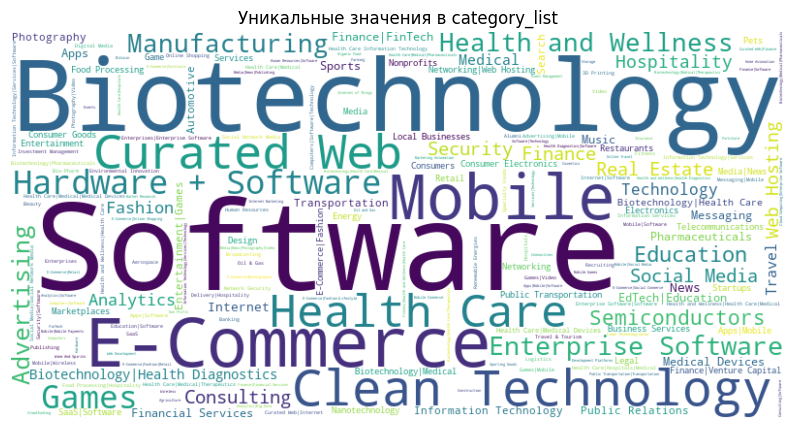

In [218]:
plot_wordcloud(train, 'category_list')

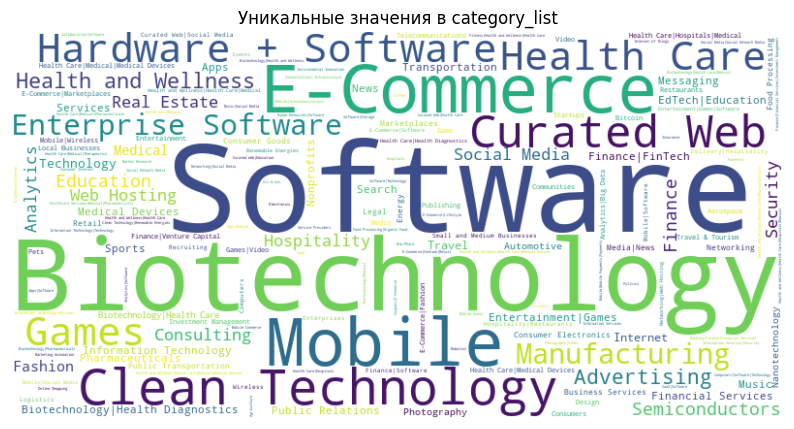

In [219]:
plot_wordcloud(test, 'category_list')

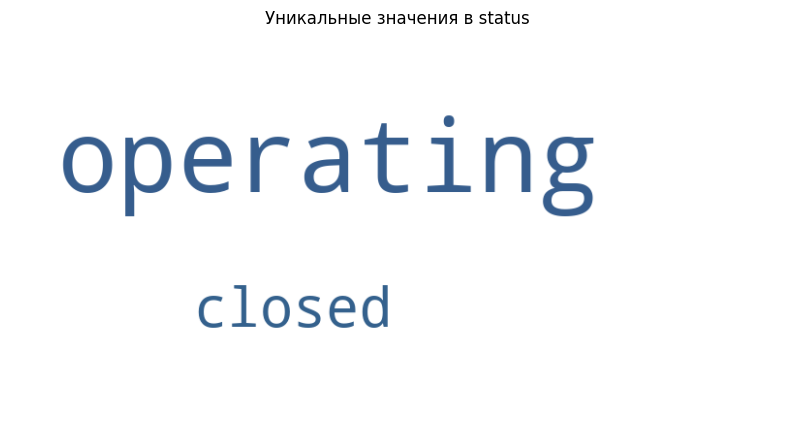

In [220]:
plot_wordcloud(train, 'status')

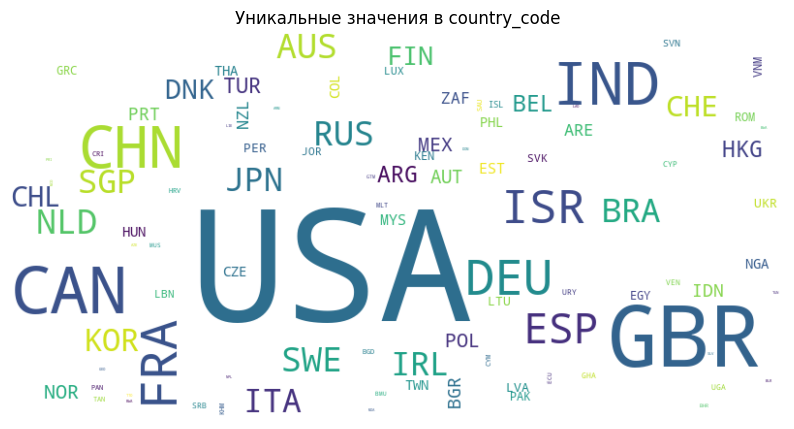

In [221]:
plot_wordcloud(train, 'country_code')

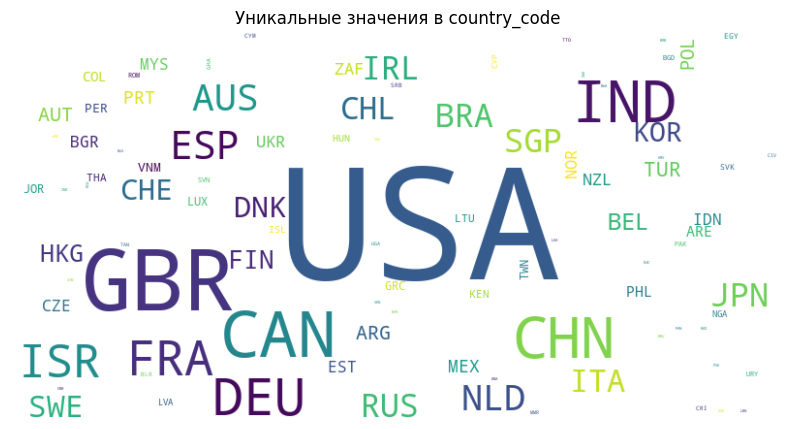

In [222]:
plot_wordcloud(test, 'country_code')

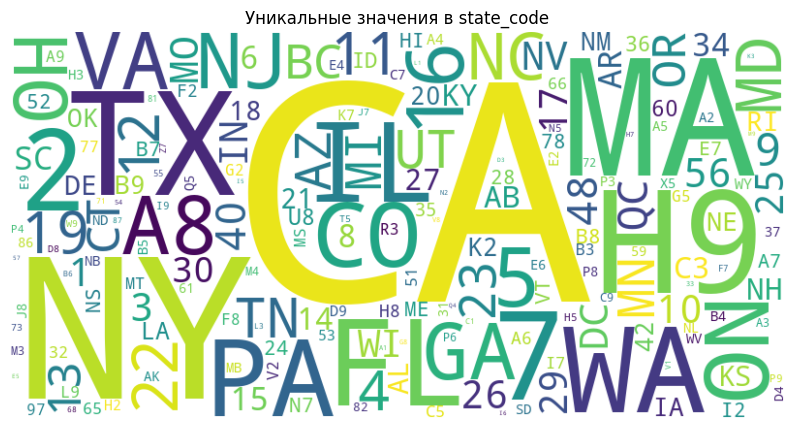

In [223]:
plot_wordcloud(train, 'state_code')

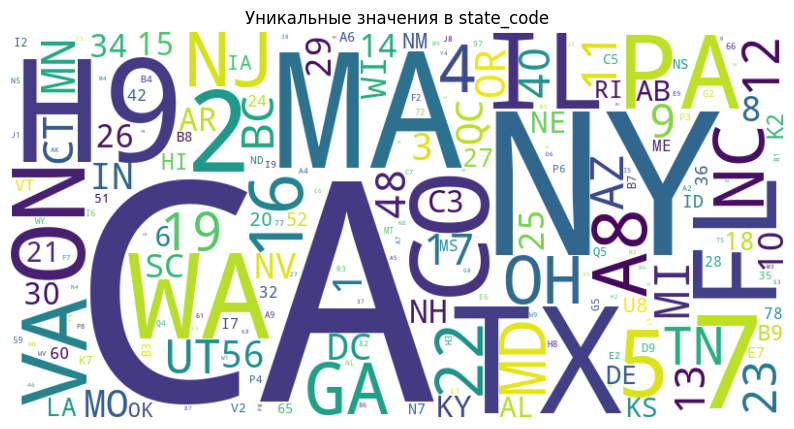

In [224]:
plot_wordcloud(test, 'state_code')

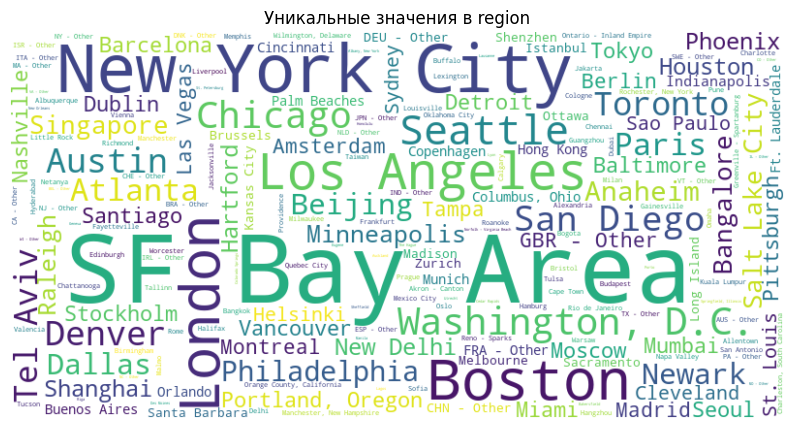

In [225]:
plot_wordcloud(train, 'region')

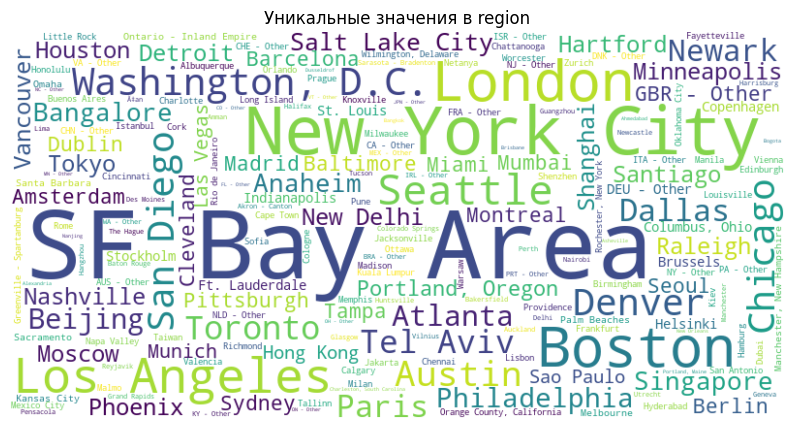

In [226]:
plot_wordcloud(test, 'region')

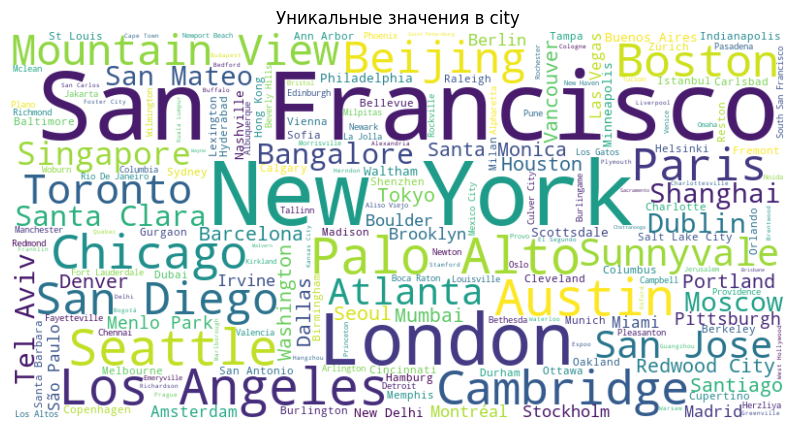

In [227]:
plot_wordcloud(train, 'city')

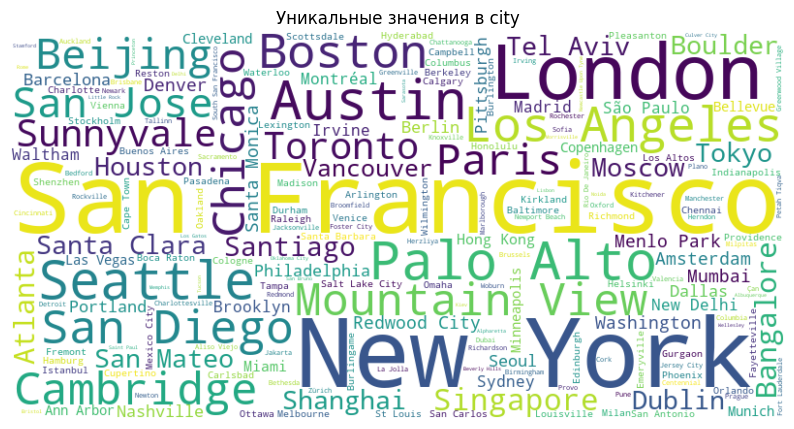

In [228]:
plot_wordcloud(test, 'city')

**Вывод:** Визуально проверить уникальные значения достаточно сложно для этих датасетов, так число уникальных значений в категориальных достаточно велико. Как таковых явных ошибок в написание значений я не вижу. Стоит подумать, как укрупнить категории стартапов и страны.  Думаю, что категорий стартапов можно укрупнить на основе часто встречающиеся категории. 
Страны можно объеденить по материкам.

Признаки `state_code`, `region`, `city` не требуется укрупнять, они несут более детальную информацию о расположении стартапа. 

Но перед укрупнением заполню пропуски. Для всех категориальных значений заполню пропуски заглушкой `unknown`. А количественный признак `funding_total_usd` - медианой с учетом раунада инвестирования.

### Работа с пропусками

В датасетах есть пропуски в категориальных и количественном столбцах. В начале посмотрю наличие пропусков в датасетах.

In [229]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52504 entries, 0 to 52503
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    52503 non-null  object        
 1   category_list           50046 non-null  object        
 2   funding_total_usd       42443 non-null  float64       
 3   status                  52504 non-null  object        
 4   country_code            47009 non-null  object        
 5   state_code              45748 non-null  object        
 6   region                  46152 non-null  object        
 7   city                    46152 non-null  object        
 8   funding_rounds          52504 non-null  int64         
 9   founded_at              52504 non-null  datetime64[ns]
 10  first_funding_at        52504 non-null  datetime64[ns]
 11  last_funding_at         52504 non-null  datetime64[ns]
 12  founded_at_year         52504 non-null  int32 

In [230]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    13125 non-null  object        
 1   category_list           12534 non-null  object        
 2   funding_total_usd       10547 non-null  float64       
 3   country_code            11743 non-null  object        
 4   state_code              11430 non-null  object        
 5   region                  11536 non-null  object        
 6   city                    11538 non-null  object        
 7   funding_rounds          13125 non-null  int64         
 8   founded_at              13125 non-null  datetime64[ns]
 9   first_funding_at        13125 non-null  datetime64[ns]
 10  last_funding_at         13125 non-null  datetime64[ns]
 11  lifetime                13125 non-null  int64         
 12  founded_at_year         13125 non-null  int32 

Пропуски присутствуют в следующих признаках: `name`, `category_list`, `funding_total_usd`, `country_code`, `state_code`, `region`, `city`.

In [231]:
col_cat = ['name', 'category_list', 'country_code', 'state_code', 'region', 'city']
col_num = ['funding_rounds', 'funding_total_usd']

col_date = ['founded_at', 'first_funding_at', 'last_funding_at']

all_columns = col_cat + col_num + col_date + [
    'founded_at_year', 'founded_at_month', 
    'first_funding_at_year', 'first_funding_at_month', 
    'last_funding_at_year', 'last_funding_at_month', 
    'lifetime', 'lifetime_first', 'lifetime_funding'
]

Теперь создам функцию для заполнения медианой в зависимости от числа раундов.

In [232]:
class MedianImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.medians = X.groupby('funding_rounds')['funding_total_usd'].median()
        return self
    
    def transform(self, X):
        def fill_median(row):
            if pd.isna(row['funding_total_usd']):
                return self.medians[row['funding_rounds']]
            else:
                return row['funding_total_usd']
        
        X['funding_total_usd'] = X.apply(fill_median, axis=1)
        return X

А теперь с помощью пайплайна заполню пропуски.

In [233]:
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown'))
])

num_pipeline = Pipeline(steps=[
    ('imputer', MedianImputer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, col_cat),
        ('num', num_pipeline, col_num)
    ],
    remainder='passthrough'  # для сохранения остальных столбцов без изменений
)

X_train = train.drop(columns=['status'])
X_test = test.copy()

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

train_transformed = pd.DataFrame(X_train_transformed, columns=all_columns)
test_transformed = pd.DataFrame(X_test_transformed, columns=all_columns)

train_transformed['status'] = train['status'].values

train = train_transformed
test = test_transformed

In [234]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52504 entries, 0 to 52503
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    52504 non-null  object        
 1   category_list           52504 non-null  object        
 2   country_code            52504 non-null  object        
 3   state_code              52504 non-null  object        
 4   region                  52504 non-null  object        
 5   city                    52504 non-null  object        
 6   funding_rounds          52504 non-null  object        
 7   funding_total_usd       52504 non-null  object        
 8   founded_at              52504 non-null  datetime64[ns]
 9   first_funding_at        52504 non-null  datetime64[ns]
 10  last_funding_at         52504 non-null  datetime64[ns]
 11  founded_at_year         52504 non-null  object        
 12  founded_at_month        52504 non-null  object

In [235]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    13125 non-null  object        
 1   category_list           13125 non-null  object        
 2   country_code            13125 non-null  object        
 3   state_code              13125 non-null  object        
 4   region                  13125 non-null  object        
 5   city                    13125 non-null  object        
 6   funding_rounds          13125 non-null  object        
 7   funding_total_usd       13125 non-null  object        
 8   founded_at              13125 non-null  datetime64[ns]
 9   first_funding_at        13125 non-null  datetime64[ns]
 10  last_funding_at         13125 non-null  datetime64[ns]
 11  founded_at_year         13125 non-null  object        
 12  founded_at_month        13125 non-null  object

Пайплайн заполнил пропуски, но слетели типы данных практически для всех столбцов. Это связано с тем, что `ColumnTransformer` и `Pipeline` не сохраняют типы данных при трансформации, так как выходные данные конвертируются в numpy массив. Для всех числовых признаков вернем тип данных.

In [236]:
convert_columns = {
    'funding_rounds': int,
    'funding_total_usd': float,
    'founded_at_year': int,
    'founded_at_month': int,
    'first_funding_at_year': int,
    'first_funding_at_month': int,
    'last_funding_at_year': int,
    'last_funding_at_month': int,
    'lifetime': int,
    'lifetime_first': int,
    'lifetime_funding': int
}

In [237]:
train = train.astype(convert_columns)
test = test.astype(convert_columns)

**Вывод:** С помощью пайплайна заполнила пропуски в тренировочной и тестовых данных. Также на этом шаге заметила, что при заполнение пропусков меняется тип данных.

### Укрупнение по материкам <a id='24'></a>

Чтобы добавить материки к датасетам использую библиотеку `pycountry`. У этой библиотеки есть метод `country_alpha2_to_continent_code`, с помощью которого можно передать код страны, а как результат получу двухбуквенный код континента.

In [238]:
class CountryConverter:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.country_miss = {
            'ROM': 'EU',  # Румыния (Europe)
            'TAN': 'AF',  # Танзания (Africa)
            'BAH': 'NA',  # Багамские острова (North America)
        }

    def convert_country_codes(self, df):
        df['country_code_alpha_3'] = df['country_code'].apply(lambda x: pycountry.countries.get(alpha_3=x))
        return df

    def get_continent_alpha3(self, country_code):
        try:
            alpha_2 = country_code.alpha_2
            return pc.country_alpha2_to_continent_code(alpha_2)
        except AttributeError:
            return None

    def add_continent_column(self, df):
        df['continent'] = df['country_code_alpha_3'].apply(self.get_continent_alpha3)
        return df

    def fill_missing_continents(self, df):
        df['continent'].fillna(df['country_code'].map(self.country_miss), inplace=True)
        return df

    def preprocess(self):
        self.train = self.convert_country_codes(self.train)
        self.test = self.convert_country_codes(self.test)
        self.train = self.add_continent_column(self.train)
        self.test = self.add_continent_column(self.test)
        
        self.train = self.fill_missing_continents(self.train)
        self.test = self.fill_missing_continents(self.test)
        
        self.train.drop(columns=['country_code_alpha_3'], inplace=True)
        self.test.drop(columns=['country_code_alpha_3'], inplace=True)
        
        return self.train, self.test

    def print_info(self):
        print("Первые 5 строк train DataFrame:")
        display(self.train.head())
        print("\nПервые 5 строк test DataFrame:")
        display(self.test.head())

In [239]:
country_converter = CountryConverter(train, test)
train_processed, test_processed = country_converter.preprocess()

country_converter.print_info()

Первые 5 строк train DataFrame:


C:\Users\ksyub\AppData\Local\Temp\ipykernel_9736\2497361448.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['continent'].fillna(df['country_code'].map(self.country_miss), inplace=True)
C:\Users\ksyub\AppData\Local\Temp\ipykernel_9736\2497361448.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

name                          category_list country_code  \
0               Lunchgate        Online Reservations|Restaurants          CHE   
1                 EarLens  Manufacturing|Medical|Medical Devices          USA   
2  Reviva Pharmaceuticals                          Biotechnology          USA   
3    Sancilio and Company                            Health Care      unknown   
4     WireTough Cylinders                          Manufacturing          USA   

  state_code       region          city  funding_rounds  funding_total_usd  \
0         25       Zurich        Zürich               2        828626.0000   
1         CA  SF Bay Area  Redwood City               4      42935019.0000   
2         CA  SF Bay Area      San Jose               3      35456381.0000   
3    unknown      unknown       unknown               3      22250000.0000   
4         VA   VA - Other       Bristol               1        860000.0000   

  founded_at first_funding_at last_funding_at  founded_at_year  \
0 2009-12-31       2011-05-01      2014-12-01             2009   
1 2005-01-01       2010-05-04      2014-02-25             2005   
2 2006-01-01       2012-08-20      2014-07-02             2006   
3 2004-01-01       2011-09-01      2014-07-18             2004   
4 2010-09-30       2012-02-01      2012-02-01             2010   

   founded_at_month  first_funding_at_year  first_funding_at_month  \
0                12                   2011                       5   
1                 1                   2010                       5   
2                 1                   2012                       8   
3                 1                   2011                       9   
4                 9                   2012                       2   

   last_funding_at_year  last_funding_at_month  lifetime  lifetime_first  \
0                  2014                     12      2923             486   
1                  2014                      2      4748            1949   
2                  2014                      7      4383            2423   
3                  2014                      7      5114            2800   
4                  2012                      2      2650             489   

   lifetime_funding     status continent  
0              1310  operating        EU  
1              1393  operating        NA  
2               681  operating        NA  
3              1051  operating       NaN  
4                 0  operating        NA


Первые 5 строк test DataFrame:


name                   category_list country_code  \
0              Crystalsol                Clean Technology          NIC   
1        JBI Fish & Wings                     Hospitality          USA   
2                COINPLUS                         Finance          LUX   
3  Imagine Communications  Software|Video|Video Streaming          USA   
4                   DNA13                        Software          CAN   

  state_code            region              city  funding_rounds  \
0         17           unknown           unknown               1   
1         TN        TN - Other          Humboldt               1   
2          3  Esch-sur-alzette  Esch-sur-alzette               2   
3         CA         San Diego         San Diego               4   
4         ON            Ottawa            Ottawa               1   

   funding_total_usd founded_at first_funding_at last_funding_at  \
0       2819200.0000 2008-06-01       2009-07-01      2009-07-01   
1        860000.0000 2010-07-25       2010-07-28      2010-07-28   
2        428257.0000 2014-06-16       2014-05-15      2014-09-18   
3      34700000.0000 2005-01-01       2005-01-01      2010-04-20   
4       4530000.0000 2001-01-01       2007-05-08      2007-05-08   

   founded_at_year  founded_at_month  first_funding_at_year  \
0             2008                 6                   2009   
1             2010                 7                   2010   
2             2014                 6                   2014   
3             2005                 1                   2005   
4             2001                 1                   2007   

   first_funding_at_month  last_funding_at_year  last_funding_at_month  \
0                       7                  2009                      7   
1                       7                  2010                      7   
2                       5                  2014                      9   
3                       1                  2010                      4   
4                       5                  2007                      5   

   lifetime  lifetime_first  lifetime_funding continent  
0      3501             395                 0        NA  
1      2717               3                 0        NA  
2      1295              32               126        EU  
3      4748               0              1935        NA  
4      6209            2318                 0        NA

Присутствуют пропуски, заполню их также `unknown`.

In [240]:
train['continent'] = train['continent'].fillna('unknown')
test['continent'] = test['continent'].fillna('unknown')

**Вывод:** для каждой страны определила принадлежность к материку. Заметила, что библиотека не содержала некторые коды стран, их я вручную добавила, чтобы не было пропусков в датасетах.

### Укрупнение категорий стартапов <a id='25'></a>

В тренировочном датасете количество уникальных категорий составляет `22108`, в тестовом `6206`. Чтобы их укрупнить создам плоский список всех категорий. Затем, с помощью `Counter`, посчитаю частоту каждой категории, и выберу 300 наиболее часто встречающихся категорий. Из них создам список укрупненных категорий. 

In [241]:
all_categories = list(chain(*train['category_list'].str.split('|')))

category_counts = Counter(all_categories)


most_common_categories = category_counts.most_common(300)
print(most_common_categories)

common_categories = [category for category, count in most_common_categories]

[('Software', 7016), ('Mobile', 4398), ('Biotechnology', 3668), ('E-Commerce', 3307), ('unknown', 2458), ('Curated Web', 2406), ('Social Media', 2284), ('Enterprise Software', 2193), ('Advertising', 1983), ('Health Care', 1885), ('Games', 1810), ('Internet', 1663), ('SaaS', 1595), ('Health and Wellness', 1513), ('Education', 1490), ('Analytics', 1477), ('Apps', 1468), ('Finance', 1455), ('Technology', 1441), ('Clean Technology', 1226), ('Hardware + Software', 1171), ('Services', 1136), ('Manufacturing', 1080), ('Medical', 951), ('Marketplaces', 890), ('Security', 871), ('Video', 866), ('Fashion', 832), ('Big Data', 746), ('Cloud Computing', 745), ('Entertainment', 745), ('Real Estate', 734), ('Consulting', 729), ('Travel', 724), ('Information Technology', 720), ('Music', 677), ('Networking', 671), ('Search', 670), ('Media', 666), ('Social Network Media', 664), ('News', 648), ('Sales and Marketing', 633), ('Hospitality', 633), ('Startups', 631), ('Sports', 628), ('Retail', 625), ('Finan

Теперь напишу функцию для укрупнения категорий на основе наиболее часто встречающихся ключевых слов, которая возвращает первую найденную категорию или `Other`, если совпадений нет. 

In [242]:
# Функция для укрупнения категорий на основе наиболее часто встречающихся ключевых слов
def categorize_category_list(category_list):
    categories = category_list.split('|')
    for category in categories:
        if category in common_categories:
            return category
    return 'Other'

# Применение функции к столбцу 'category_list' и создание нового столбца 'category_group'
train['category_group'] = train['category_list'].apply(categorize_category_list)
test['category_group'] = test['category_list'].apply(categorize_category_list)

**Вывод:** на этом шаге укрупила категории до 300.

### Выводы <a id='26'></a>

На этапе предобработки данных сделала следующие:

1. Добавила новые признаки основннные на датах.
2. Убрала дубликаты из тренировочного датасета.
3. Предварительно ознакомилась с уникальными значениями категориальных признаков.
4. С помощью пайплайна заполнила пропуски.
5. Для тренировочного и тестового датасета добавила принадлежность к материку.
6. Укрупнила категории стартапов до 300.

## Исследовательский анализ данных <a id='3'></a>

На исследовательском этапе нужно провести одномерный и двумерный анализ признаков. На этапе предобратки у меня получилось `19` признаков: `11` - количественных и `8` - категориальных (name, founded_at, first_funding_at, last_funding_at не беру в рассчет). Проведу анализ каждого признака, и определю, какие из них лучше всего подойдут для обучения модели.

### Одномерный анализ <a id='31'></a>

Так как в датасетах есть геоданные, для более интересной визуализации напишу класс, который определяет координаты городов.

In [243]:
class CityCoordinates:
    def __init__(self, unique_cities):
        self.unique_cities = unique_cities
        self.city_coordinates = {}
        self.filename = 'city_coordinates.pickle'

    def get_city_coordinates(self, city_name):
        geolocator = Nominatim(user_agent="abcd")
        try:
            location = geolocator.geocode(city_name, timeout=10)
            if location:
                return location.latitude, location.longitude
        except (GeocoderTimedOut, GeocoderUnavailable) as e:
            print(f"Error: {e}, city: {city_name}")
            return None

    def fill_city_coordinates(self):
        # Проверяем наличие файла с координатами
        if os.path.exists(self.filename):
            with open(self.filename, 'rb') as f:
                self.city_coordinates = pickle.load(f)
        else:
            # Заполняем словарь координатами для каждого города (если файл отсутствует)
            for city in self.unique_cities:
                coordinates = self.get_city_coordinates(city)
                if coordinates:
                    self.city_coordinates[city] = coordinates
                time.sleep(1)  # задержка между запросами

    def save_coordinates_to_file(self):
        # Сохраняем словарь в файл
        with open(self.filename, 'wb') as f:
            pickle.dump(self.city_coordinates, f)

    def add_coordinates_to_dataframe(self, df):
        # Создаем новые столбцы для долготы и широты
        df['latitude'] = df['city'].map(lambda city: self.city_coordinates.get(city, (None, None))[0])
        df['longitude'] = df['city'].map(lambda city: self.city_coordinates.get(city, (None, None))[1])
        return df

In [244]:
# Получение уникальных городов из датасетов train и test
unique_cities_train = train[train['city'] != 'unknown']['city'].unique()
unique_cities_test = test[test['city'] != 'unknown']['city'].unique()
unique_cities = set(unique_cities_train) | set(unique_cities_test)

# Инициализация объекта с уникальными городами
city_coords = CityCoordinates(unique_cities)

In [245]:
city_coords.fill_city_coordinates()

In [246]:
city_coords.save_coordinates_to_file()

In [247]:
train = city_coords.add_coordinates_to_dataframe(train)
test = city_coords.add_coordinates_to_dataframe(test)


display(train.head())
display(test.head())

name                          category_list country_code  \
0               Lunchgate        Online Reservations|Restaurants          CHE   
1                 EarLens  Manufacturing|Medical|Medical Devices          USA   
2  Reviva Pharmaceuticals                          Biotechnology          USA   
3    Sancilio and Company                            Health Care      unknown   
4     WireTough Cylinders                          Manufacturing          USA   

  state_code       region          city  funding_rounds  funding_total_usd  \
0         25       Zurich        Zürich               2        828626.0000   
1         CA  SF Bay Area  Redwood City               4      42935019.0000   
2         CA  SF Bay Area      San Jose               3      35456381.0000   
3    unknown      unknown       unknown               3      22250000.0000   
4         VA   VA - Other       Bristol               1        860000.0000   

  founded_at first_funding_at last_funding_at  founded_at_year  \
0 2009-12-31       2011-05-01      2014-12-01             2009   
1 2005-01-01       2010-05-04      2014-02-25             2005   
2 2006-01-01       2012-08-20      2014-07-02             2006   
3 2004-01-01       2011-09-01      2014-07-18             2004   
4 2010-09-30       2012-02-01      2012-02-01             2010   

   founded_at_month  first_funding_at_year  first_funding_at_month  \
0                12                   2011                       5   
1                 1                   2010                       5   
2                 1                   2012                       8   
3                 1                   2011                       9   
4                 9                   2012                       2   

   last_funding_at_year  last_funding_at_month  lifetime  lifetime_first  \
0                  2014                     12      2923             486   
1                  2014                      2      4748            1949   
2                  2014                      7      4383            2423   
3                  2014                      7      5114            2800   
4                  2012                      2      2650             489   

   lifetime_funding     status continent       category_group  latitude  \
0              1310  operating        EU  Online Reservations   47.3744   
1              1393  operating        NA        Manufacturing   37.4863   
2               681  operating        NA        Biotechnology   37.3362   
3              1051  operating   unknown          Health Care       NaN   
4                 0  operating        NA        Manufacturing   51.4538   

   longitude  
0     8.5410  
1  -122.2325  
2  -121.8906  
3        NaN  
4    -2.5973

name                   category_list country_code  \
0              Crystalsol                Clean Technology          NIC   
1        JBI Fish & Wings                     Hospitality          USA   
2                COINPLUS                         Finance          LUX   
3  Imagine Communications  Software|Video|Video Streaming          USA   
4                   DNA13                        Software          CAN   

  state_code            region              city  funding_rounds  \
0         17           unknown           unknown               1   
1         TN        TN - Other          Humboldt               1   
2          3  Esch-sur-alzette  Esch-sur-alzette               2   
3         CA         San Diego         San Diego               4   
4         ON            Ottawa            Ottawa               1   

   funding_total_usd founded_at first_funding_at last_funding_at  \
0       2819200.0000 2008-06-01       2009-07-01      2009-07-01   
1        860000.0000 2010-07-25       2010-07-28      2010-07-28   
2        428257.0000 2014-06-16       2014-05-15      2014-09-18   
3      34700000.0000 2005-01-01       2005-01-01      2010-04-20   
4       4530000.0000 2001-01-01       2007-05-08      2007-05-08   

   founded_at_year  founded_at_month  first_funding_at_year  \
0             2008                 6                   2009   
1             2010                 7                   2010   
2             2014                 6                   2014   
3             2005                 1                   2005   
4             2001                 1                   2007   

   first_funding_at_month  last_funding_at_year  last_funding_at_month  \
0                       7                  2009                      7   
1                       7                  2010                      7   
2                       5                  2014                      9   
3                       1                  2010                      4   
4                       5                  2007                      5   

   lifetime  lifetime_first  lifetime_funding continent    category_group  \
0      3501             395                 0        NA  Clean Technology   
1      2717               3                 0        NA       Hospitality   
2      1295              32               126        EU           Finance   
3      4748               0              1935        NA          Software   
4      6209            2318                 0        NA          Software   

   latitude  longitude  
0       NaN        NaN  
1   40.5997  -123.8998  
2   49.4960     5.9850  
3   32.7174  -117.1628  
4   45.4209   -75.6901

`latitude`, `longitude` - содержат координаты городов, в некоторых записях есть пропуски, их заполнять не требуется, т.к. не получится определить долготу и широту для неизвестного города.

Теперь создам класс, в котором будет хранится построение графиков:
- `plot_count_distribution` - столбчатый график для категориальных признаков. Нужен для общего ознакомления с категориальными признаками. Подходит для признаков, которые имеют небольшое количество уникальных значений.
- `plot_world_map` -  визуализирует распределение значений по странам на карте мира и добавляет топ-10 городов. Здесь использовала логарифмическую шкалу, так как есть перевес у США.
- `num_analysis` - построенние гистограммы и ящика с усами для количественных значений, также добавила тест Шапиро-Уилка для определения нормальности распределения и описательную статистику.
- `plot_startup_months` - построение столбчатого графика сезонности для стартапов.
- `plot_status_distribution_by_month` - построение столбчатого графика сезонности для стартапов в зависимости от статуса.
- `chi2_test` - проверка значимости месяца или года от статуса.
- `plot_startup_creation_years` - график количества стартапов по годам.
- `plot_startup_status_by_year_lineplot` - график распределение статусов стартапов по годам.
- `plot_top_categories` - столбчатый график с выводом топ-20 категорий.

In [248]:
class DataVisualizer:
    def __init__(self):
        pass

    def plot_count_distribution(self, data, column):
        # Убираем значения 'unknown'
        data_filtered = data[data[column] != 'unknown']

        plt.figure(figsize=(10, 6))
        ax = sns.countplot(data=data_filtered, x=column, order=data_filtered[column].value_counts().index)

        ax.set(xlabel=None)
        plt.ylabel('Частота')
        plt.title(f'Частота распределения {column}')

        for p in ax.patches:
            height = p.get_height()
            percentage = height / len(data_filtered) * 100
            ax.annotate(f'{height}\n({percentage:.1f}%)', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

        plt.show()

    def plot_world_map(self, data, column, dataset_name):
        # Загружаем геоданные мира
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        
        data = data[data['city'] != 'unknown']
        country_counts = data[column].value_counts()
        
        country_data = pd.DataFrame({
            'country_code': country_counts.index,
            'counts': country_counts.values
        })
        
        world_data = world.merge(country_data, left_on='iso_a3', right_on='country_code', how='left')

        # Применение логарифмической шкалы
        world_data['log_counts'] = np.log1p(world_data['counts'])

        # Построение карты
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        world.boundary.plot(ax=ax)
        world_data.plot(column='log_counts', ax=ax, legend=True,
                        legend_kwds={'label': "Логарифм числа вхождений по странам",
                                     'orientation': "horizontal"},
                        missing_kwds={"color": "lightgrey"})
        
        # Добавление точек городов
        if 'latitude' in data.columns and 'longitude' in data.columns:
            # Найти топ-10 городов по числу уникальных значений
            top_cities_data = data['city'].value_counts().head(10)
            top_cities = top_cities_data.index
            
            top_cities_data = data[data['city'].isin(top_cities) & data['latitude'].apply(np.isfinite) & data['longitude'].apply(np.isfinite)]
            
            gdf_points = gpd.GeoDataFrame(top_cities_data, geometry=gpd.points_from_xy(top_cities_data['longitude'], top_cities_data['latitude']))
            gdf_points.plot(ax=ax, color='red', markersize=20, label='Топ-10 городов')

            for x, y, label in zip(top_cities_data['longitude'], top_cities_data['latitude'], top_cities_data['city']):
                ax.text(x, y, f'{label} ({top_cities_data[top_cities_data["city"] == label].shape[0]})', fontsize=8, ha='right', color='black', weight='normal')

        plt.title(f'{column} Страны по числу стартапов в {dataset_name}')
        plt.legend(loc='lower left')
        plt.show()

              
    def num_analysis(self, data, num, bin_num=20, r=0):
        
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 6))
        
        sns.boxplot(x=data[num], ax=ax_box).set_title(f'Распределение {num}', fontsize=25)
        
        if r == 0:
            sns.histplot(data=data, x=num, ax=ax_hist, bins=bin_num)
        else:
            value_counts = data[num].value_counts()
            relative_frequencies = data[num].value_counts(normalize=True)

            ax = sns.countplot(data=data, x=num, order=value_counts.index)
            for i, (freq, count) in enumerate(zip(relative_frequencies, value_counts)):
                ax.annotate(f'{count} ({freq:.2f})', xy=(i, count), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=15)

        ax_box.set(xlabel='')
        plt.xlabel(f'{num}', fontsize=15)
        plt.ylabel('Частота', fontsize=15)

        plt.axvline(x=data[num].mean(), color='g', linestyle='-', label=f'mean: {data[num].mean()}')
        plt.axvline(x=data[num].median(), color='g', linestyle='--', label=f'median: {data[num].median()}')

        plt.legend()

        display(data[num].describe())
        print(shapiro(data[num]))
        
    def plot_startup_months(self, data, month_column):
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(data=data, x=month_column, order=range(1, 13))

        ax.set(xlabel='Месяц')
        plt.ylabel('Частота')
        plt.title(f'Количество стартапов по месяцам')

        for p in ax.patches:
            height = p.get_height()
            percentage = height / len(data) * 100
            ax.annotate(f'{height}\n({percentage:.1f}%)', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

        plt.show()
        
    def plot_status_distribution_by_month(self, data, month_column, status_column):
        # Создаем сводную таблицу с количеством статусов по месяцам
        month_status_counts = data.groupby([month_column, status_column]).size().unstack().fillna(0)

        plt.figure(figsize=(10, 6));
        month_status_counts.plot(kind='bar', stacked=True);
        plt.xlabel('Месяц');
        plt.ylabel('Количество стартапов');
        plt.title('Распределение статусов стартапов по месяцам');
        plt.legend(title='Статус');
        plt.show();

        return month_status_counts
    
    def chi2_test(self, month_status_counts):

        chi2, p, dof, ex = chi2_contingency(month_status_counts)
        print(f"Chi2: {chi2}, p-value: {p}")
        if p < 0.05:
            print("Существует статистически значимая зависимость между признаком и статусом стартапа.")
        else:
            print("Нет статистически значимой зависимости между признаком и статусом стартапа.")
            
    def plot_startup_creation_years(self, data, year_column):

        yearly_counts = data[year_column].value_counts().sort_index()

        plt.figure(figsize=(12, 6))
        sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o')
        plt.xlabel('Год')
        plt.ylabel('Количество стартапов')
        plt.title('Количество стартапов по годам')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_startup_status_by_year_lineplot(self, data, year_column, status_column):
        # Группируем данные по годам и статусу
        year_status_counts = data.groupby([year_column, status_column]).size().unstack(fill_value=0)
        
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=year_status_counts, markers=True, linewidth=2.5)
        plt.xlabel('Год основания')
        plt.ylabel('Количество стартапов')
        plt.title('Распределение статусов стартапов по годам')
        plt.legend(title='Статус')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_top_categories(self, data, column, top_n=20):

        top_categories = data[column].value_counts().head(top_n)

        plt.figure(figsize=(12, 8))
        sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
        plt.xlabel('Количество стартапов')
        plt.ylabel('Категория')
        plt.title(f'Топ-{top_n} категорий стартапов')
        plt.show()

In [249]:
# Создаем экземпляр класса
visualizer = DataVisualizer()

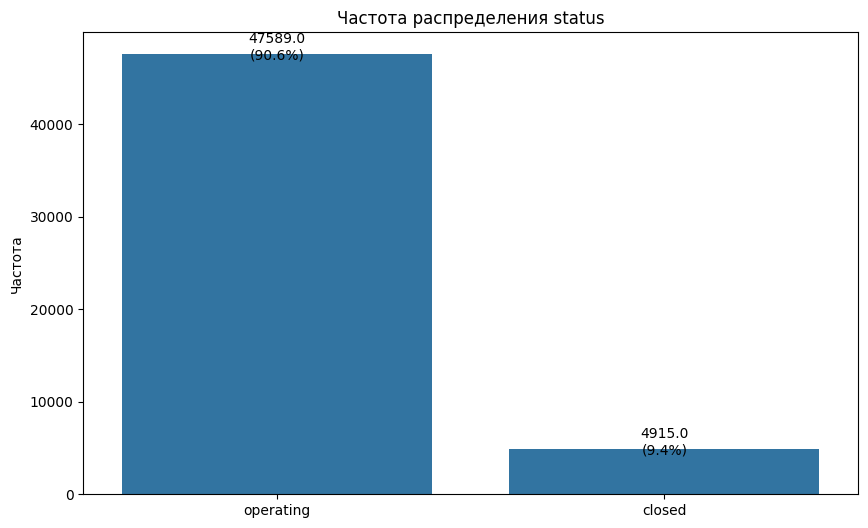

In [250]:
visualizer.plot_count_distribution(train, 'status')

У таргета присутствует диссбаланс (91% - operating, 9% - closed).

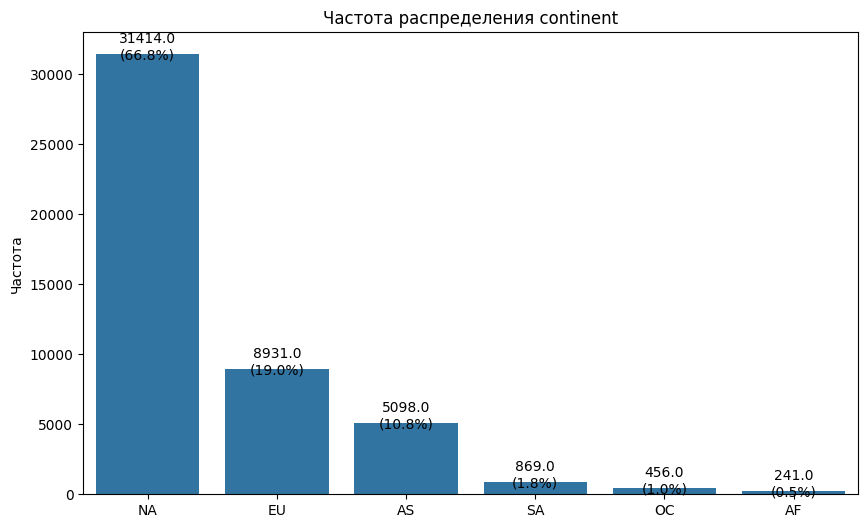

In [251]:
visualizer.plot_count_distribution(train, 'continent')

Порядка 67% стартапов находяться в Северной Америки, 19% - в Европе, 11% - в Азии.

C:\Users\ksyub\AppData\Local\Temp\ipykernel_9736\1497539935.py:27: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


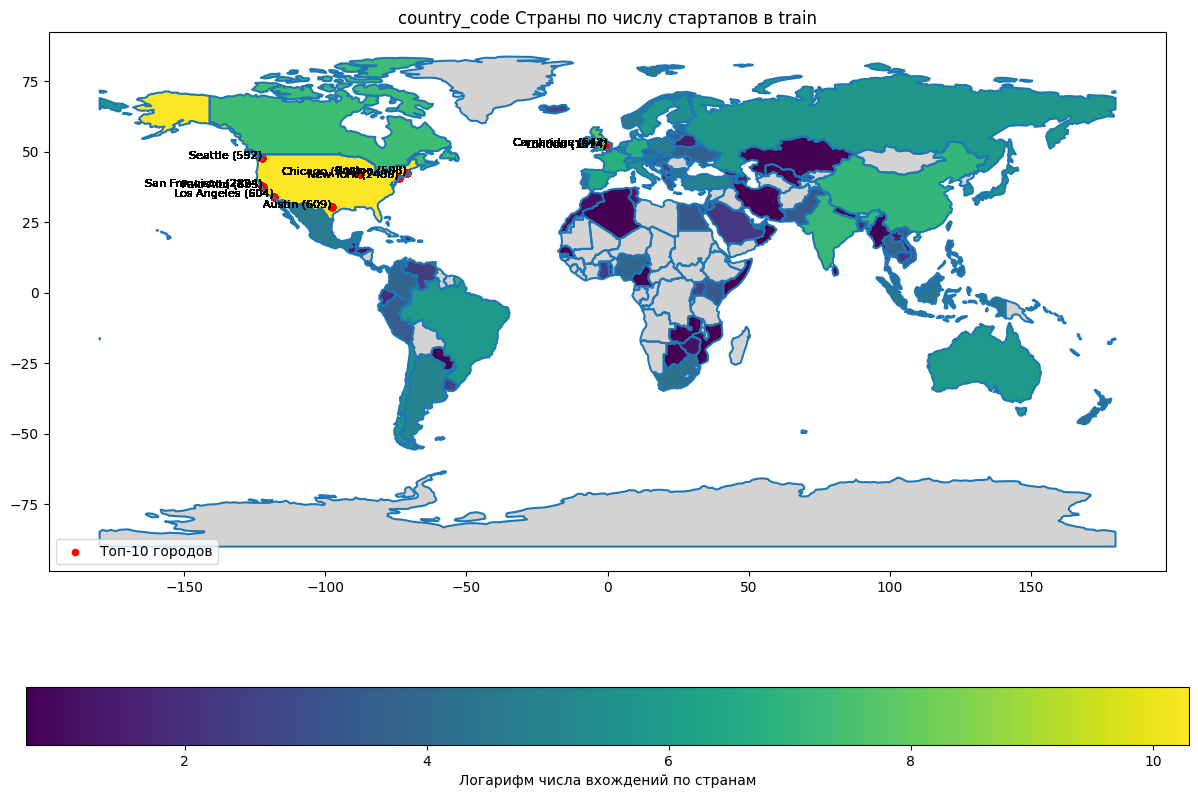

In [252]:
visualizer.plot_world_map(train, 'country_code', 'train')

Больше всего стартапов в США, Англии и Канаде, увы, Россия, к сожалению, не попала в топ 10 по странам. Что касается городов, то 10 лидеров:
- San Francisco:     2824
- New York:          2486
- London:            1514
- Austin:             609
- Palo Alto:          605
- Los Angeles:        604
- Seattle:            592
- Chicago:            546
- Cambridge:          542
- Boston:             508

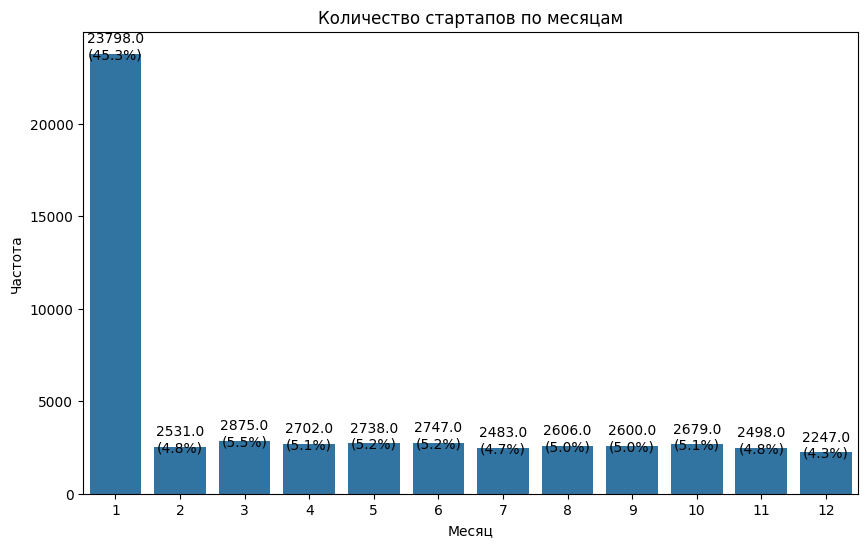

In [253]:
visualizer.plot_startup_months(train, 'founded_at_month')

Большинство стартапов основаны в январе 23798. Посмотрю также в зависимости от таргета распределение по месяцам основания. Использую критерий Хи-квадрат для определение значимости месяца основания и статуса.

Гипотеза:
- Нулевая гипотеза (H0): Месяц основания стартапа не влияет на его статус.
- Альтернативная гипотеза (H1): Месяц основания стартапа влияет на его статус.

<Figure size 1000x600 with 0 Axes>

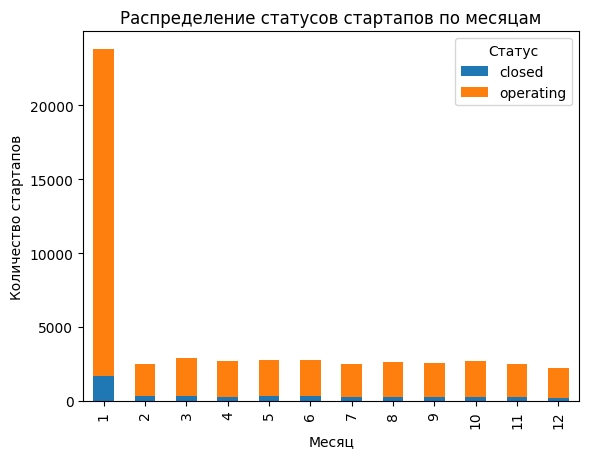

Chi2: 268.7575005931396, p-value: 3.2610664056233266e-51
Существует статистически значимая зависимость между признаком и статусом стартапа.


In [254]:
month_status_counts=visualizer.plot_status_distribution_by_month(train, 'founded_at_month', 'status')
visualizer.chi2_test(month_status_counts)

Исходя из полученного результата, отвергаю нулевую гипотезу. Месяц основания влияет на статус стартапа.

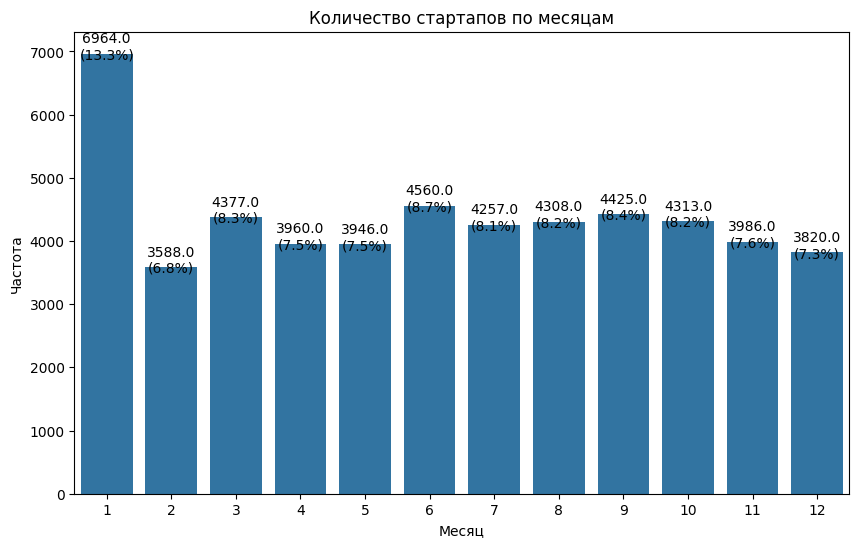

In [255]:
visualizer.plot_startup_months(train, 'first_funding_at_month')

Больше всего было профинансированно в первый месяц (январь). Аналогично посмотрю зависимость таргета от месяца начала финансирования. 

Гипотеза:
- Нулевая гипотеза (H0): Месяц начала инвестиции стартапа не влияет на его статус.
- Альтернативная гипотеза (H1): Месяц начала инвестиции стартапа влияет на его статус.

<Figure size 1000x600 with 0 Axes>

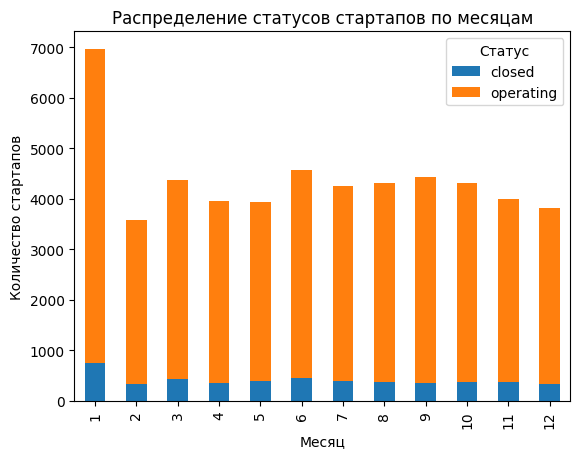

Chi2: 41.96961062169242, p-value: 1.639448395918778e-05
Существует статистически значимая зависимость между признаком и статусом стартапа.


In [256]:
month_status_counts=visualizer.plot_status_distribution_by_month(train, 'first_funding_at_month', 'status')
visualizer.chi2_test(month_status_counts)

Исходя из полученного результата, отвергаю нулевую гипотезу. Месяц начала финансирования влияет на статус стартапа.

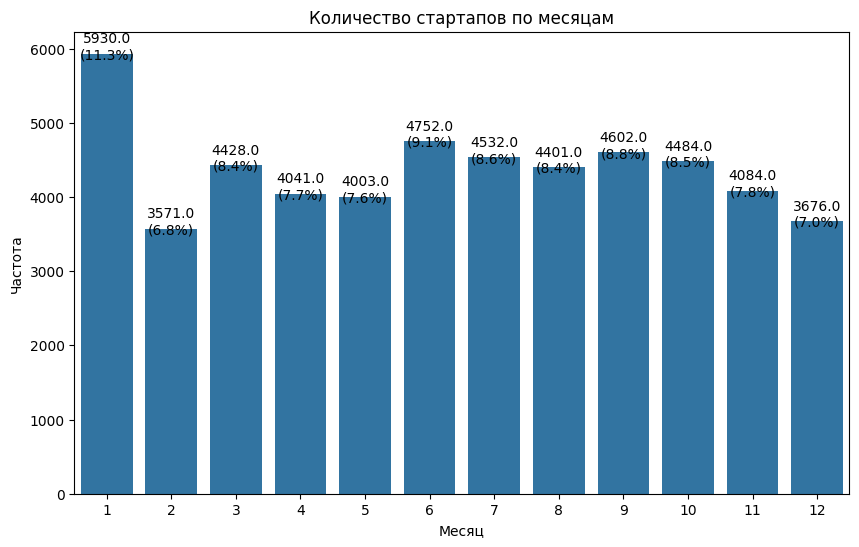

In [257]:
visualizer.plot_startup_months(train, 'last_funding_at_month')

График окончания инвестиции практически идентичен месяцу началу финансирования.

Гипотеза:
- Нулевая гипотеза (H0): Месяц окончания инвестиции стартапа не влияет на его статус.
- Альтернативная гипотеза (H1): Месяц окончания инвестиции стартапа влияет на его статус.

<Figure size 1000x600 with 0 Axes>

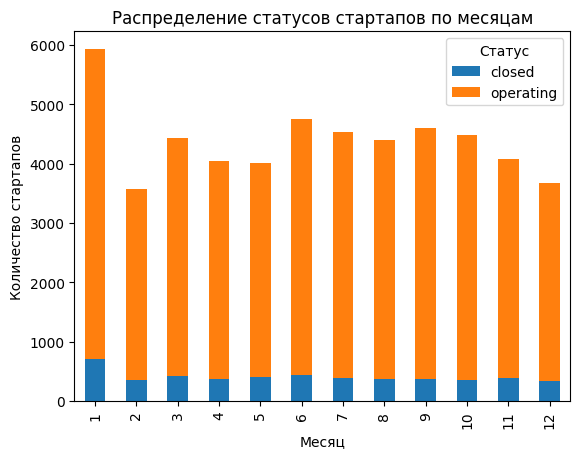

Chi2: 79.80876458180987, p-value: 1.6068676022493252e-12
Существует статистически значимая зависимость между признаком и статусом стартапа.


In [258]:
month_status_counts=visualizer.plot_status_distribution_by_month(train, 'last_funding_at_month', 'status')
visualizer.chi2_test(month_status_counts)

Также принимаю гипотезу о влияение окончания месяца инвестиции на статус.

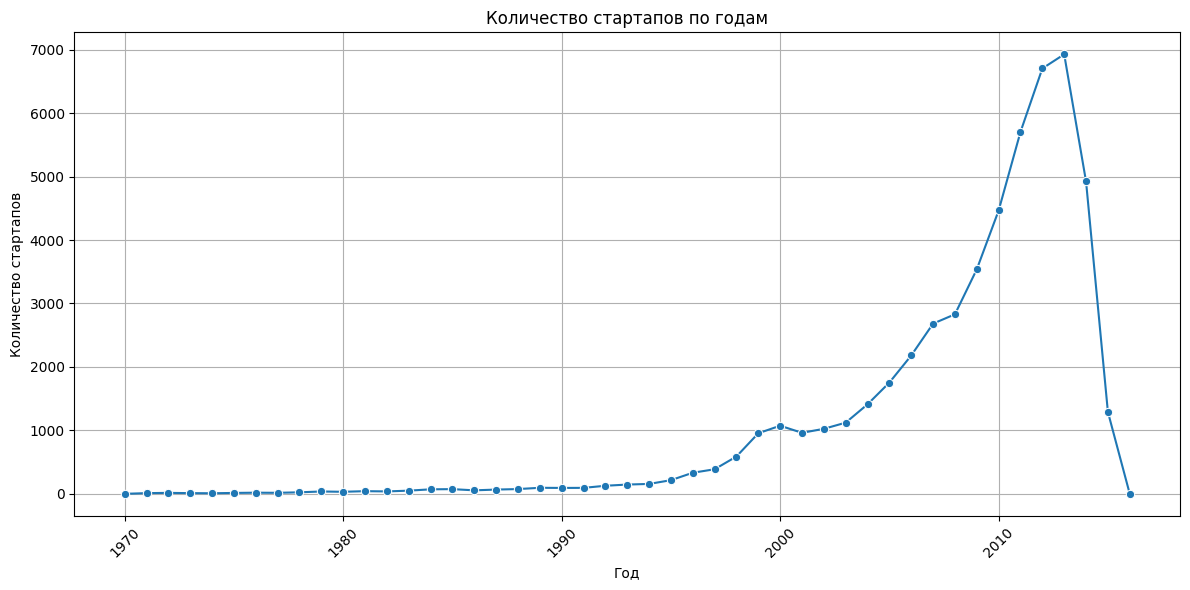

In [259]:
visualizer.plot_startup_creation_years(train, 'founded_at_year')

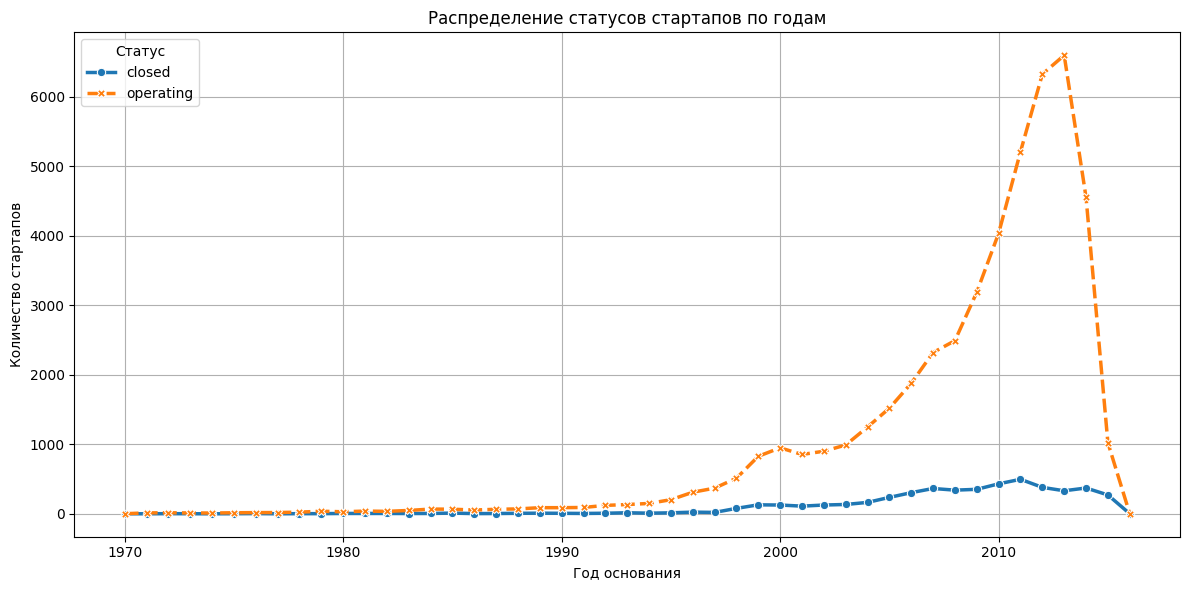

In [260]:
visualizer.plot_startup_status_by_year_lineplot(train, 'founded_at_year', 'status')

Количество стартапов начало значительно увеличиваться с 2000 года, причем видно значительное снижение с 2013 по 2015 года. Если разделять по статусам, то заметно, что число закрытых стартапов начало увеличиваться с 2000 года, заметен небольшой скачок с 2006 года и с 2014.

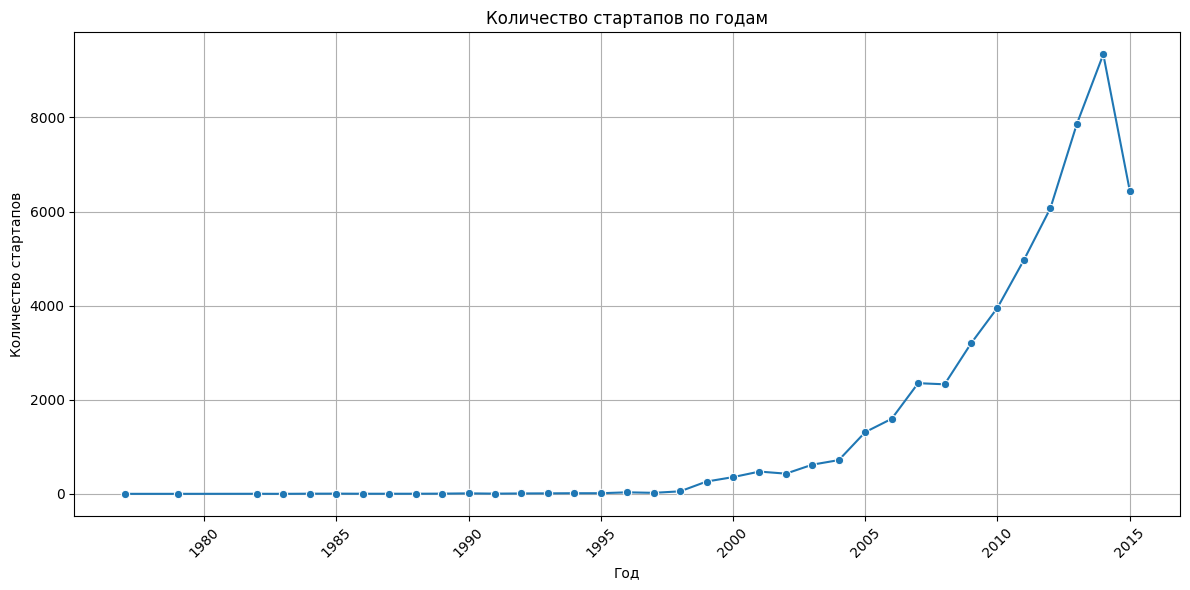

In [261]:
visualizer.plot_startup_creation_years(train, 'first_funding_at_year')

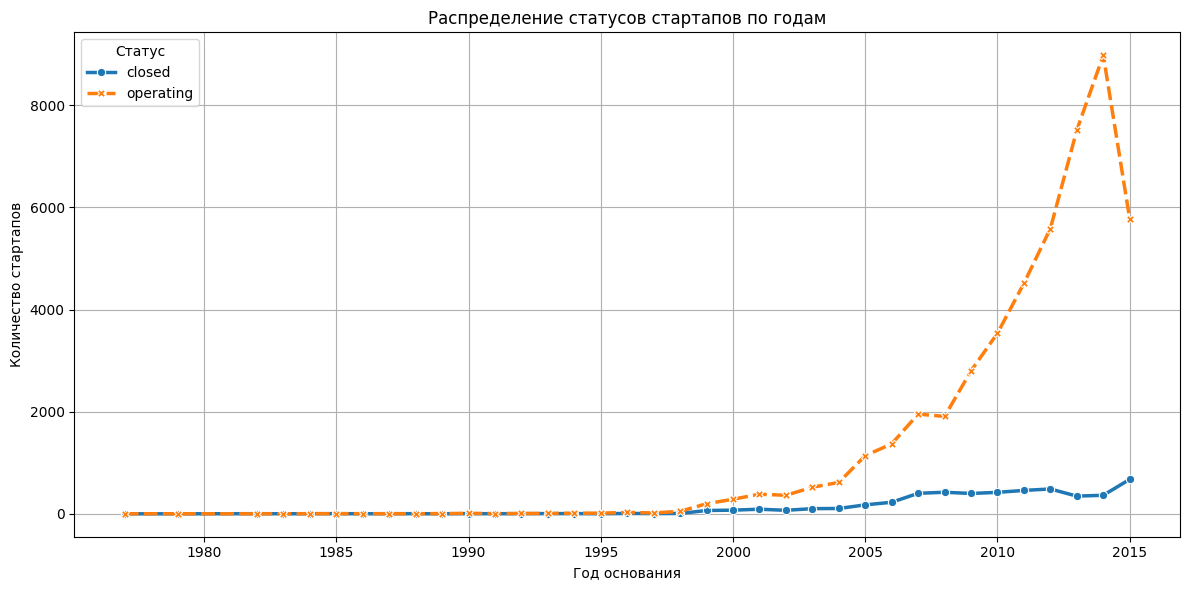

In [262]:
visualizer.plot_startup_status_by_year_lineplot(train, 'first_funding_at_year', 'status')

 Более "активно" начали инвестировать в стартапы с 2008 года, причем заметен спад с 2014 по 2015 года.

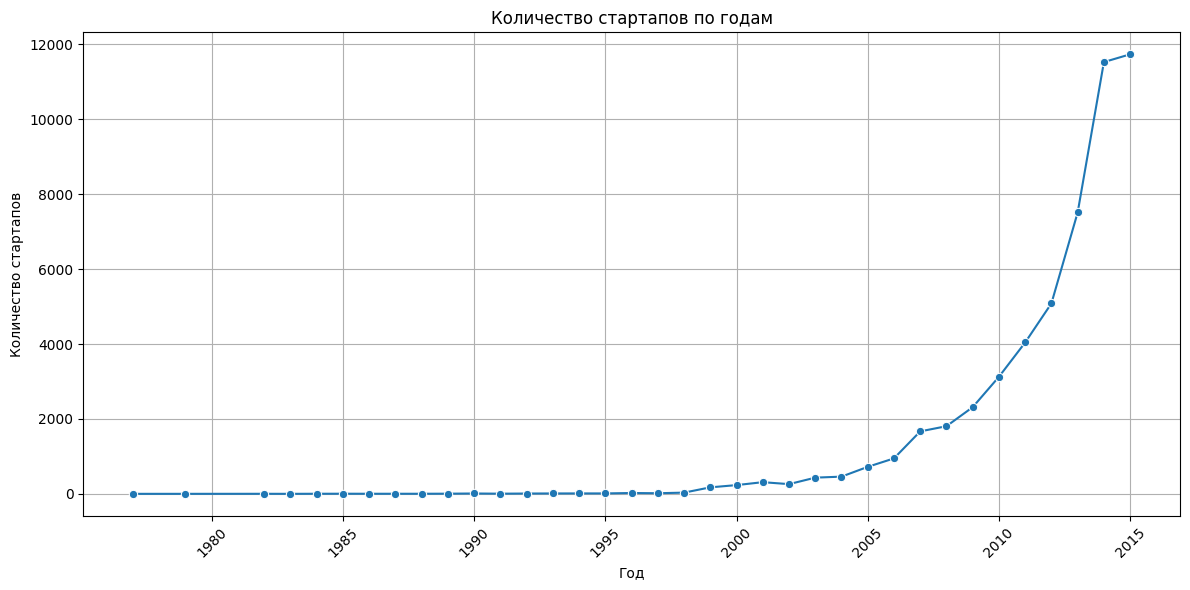

In [263]:
visualizer.plot_startup_creation_years(train, 'last_funding_at_year')

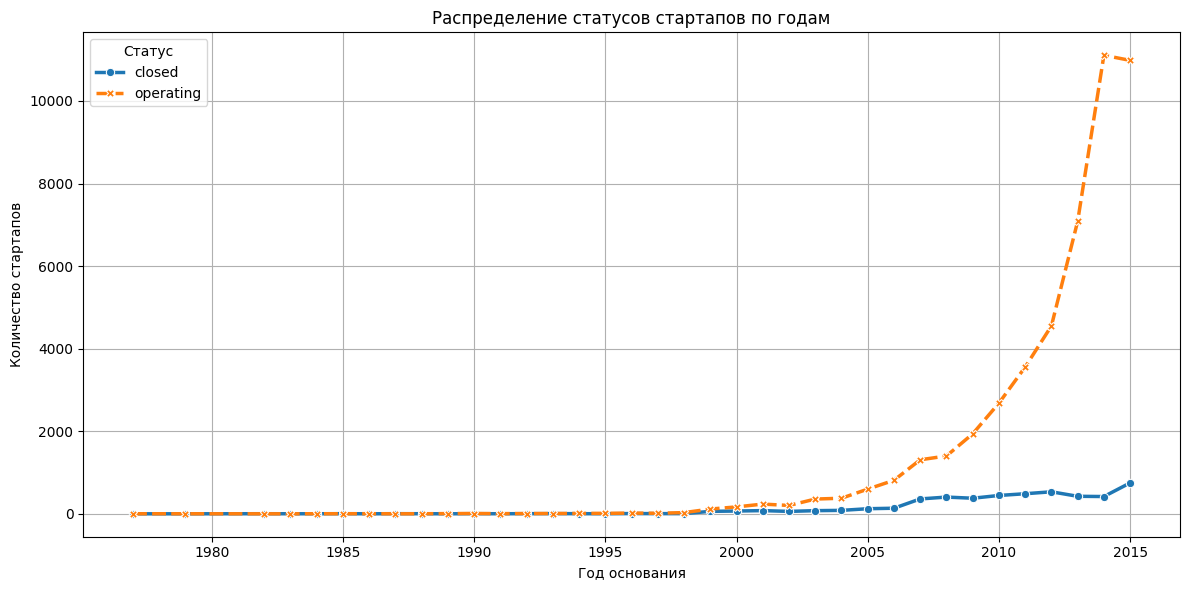

In [264]:
visualizer.plot_startup_status_by_year_lineplot(train, 'last_funding_at_year', 'status')

Окончание инвестиционного раунда заметно увеличилось с 2007 по 2015 года.

count         52504.0000
mean       14981337.2650
std       168380388.0574
min               1.0000
25%          528764.0000
50%         1022252.0000
75%         7000000.0000
max     30079503000.0000
Name: funding_total_usd, dtype: float64

ShapiroResult(statistic=0.03596597909927368, pvalue=0.0)


C:\Users\ksyub\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


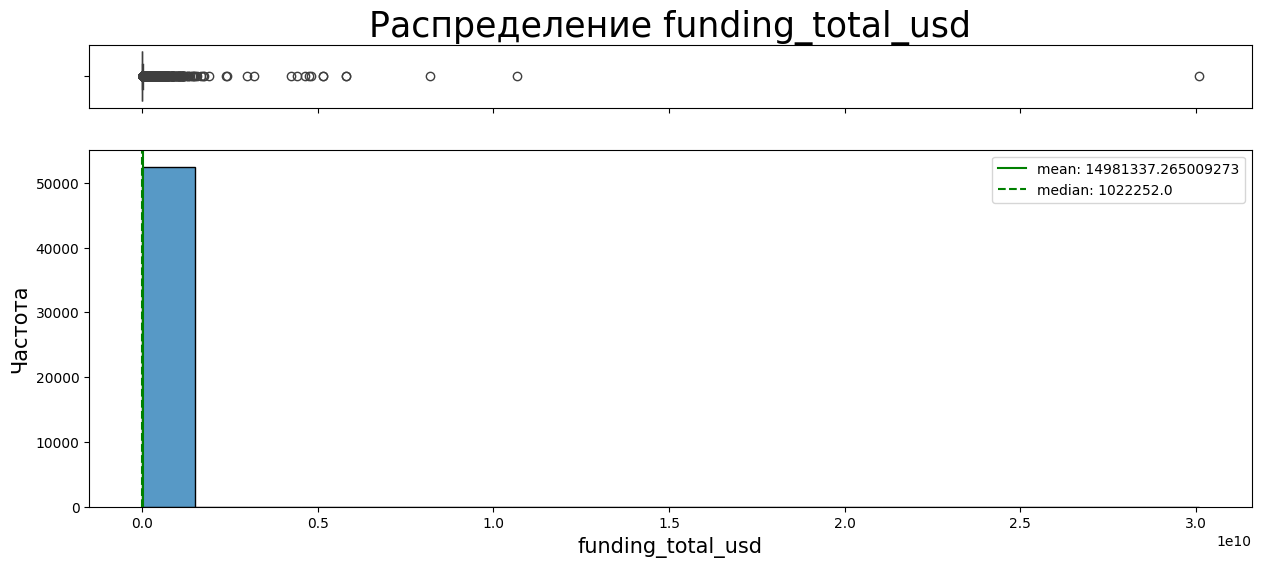

In [265]:
visualizer.num_analysis(train, 'funding_total_usd')

В среднем, сумма инвенстирования сотсавляет 7426479, а медианное значение в районе 2000000. 

В `funding_total_usd` присутствуют выбросы. Определю верхнюю границу в `150_000_000`. Также меня немного смущает сумма инвестирования в `1` доллар. Теоретически это имеет место быть, но на практике есть некторые нюансы, например, большинство инвестиционных платформ устанавливают минимальные суммы, которые могут быть значительно выше 1 доллара. Это делается из-за административных расходов на обслуживание счетов, исполнение сделок и других административных расходов. В этом случае оставлю нижнюю границу в `10_000` долларов.  Посмотрю, как изменится график.

count       51172.0000
mean      8552575.7161
std      18947961.5077
min         10100.0000
25%        568700.0000
50%       1010000.0000
75%       6500000.0000
max     149499995.0000
Name: funding_total_usd, dtype: float64

ShapiroResult(statistic=0.4851515293121338, pvalue=0.0)


C:\Users\ksyub\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


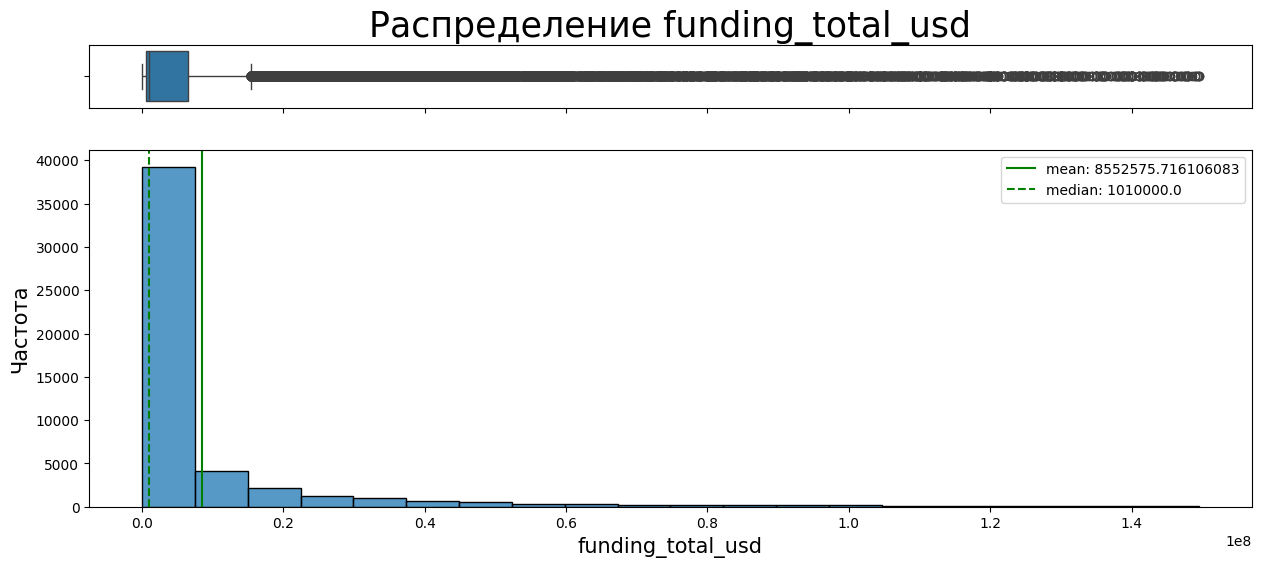

In [266]:
visualizer.num_analysis(train[(train['funding_total_usd'] < 150_000_000) & 
                              (train['funding_total_usd'] > 10_000)], 'funding_total_usd')

Посмотрю в тестовом датасете, как распределена сумма инвестирования.

count        13125.0000
mean      13537204.1628
std       82855552.9617
min              1.0000
25%         501000.0000
50%        1000000.0000
75%        6840683.0000
max     4715000000.0000
Name: funding_total_usd, dtype: float64

ShapiroResult(statistic=0.10851836204528809, pvalue=0.0)


C:\Users\ksyub\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


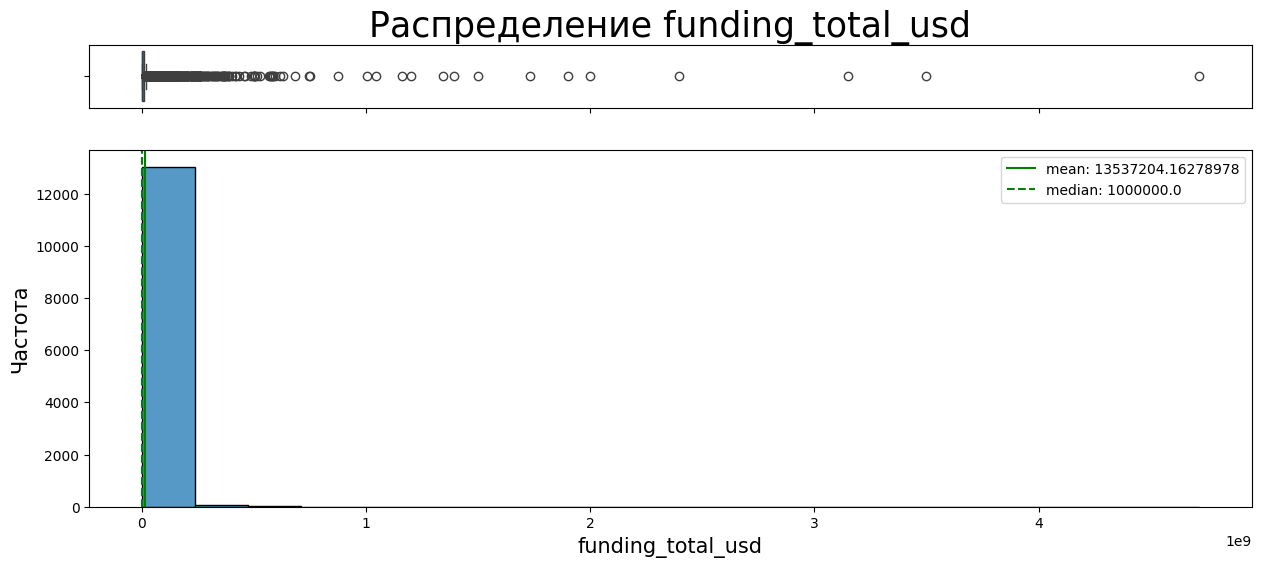

In [267]:
visualizer.num_analysis(test, 'funding_total_usd')

В тестовом также есть выбросы. Вижу здесь 2 пути решения: либо оставить все как есть, либо задать границу, так как думаю, что при удаление строк из `train` модель не сможет в дальнейшем верно предсказать статус. Оставлю пока как есть.

count   52504.0000
mean     3141.3350
std      2147.9888
min        17.0000
25%      1740.0000
50%      2557.0000
75%      4018.0000
max     17378.0000
Name: lifetime, dtype: float64

ShapiroResult(statistic=0.8278099894523621, pvalue=0.0)


C:\Users\ksyub\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


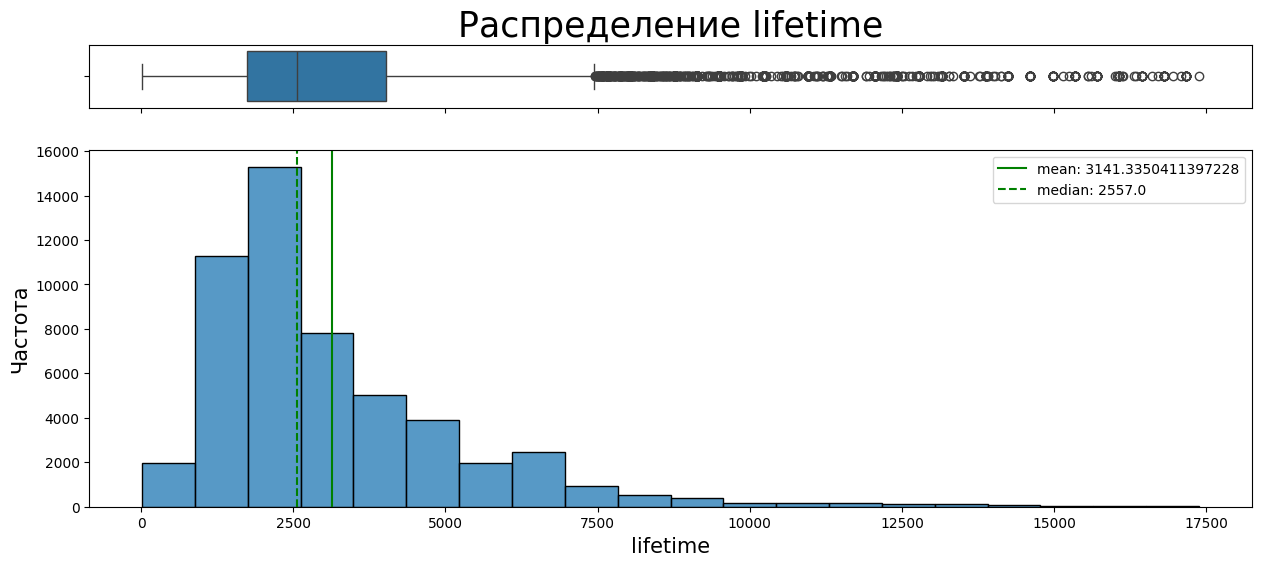

In [268]:
visualizer.num_analysis(train, 'lifetime')

В среднем стартапы существуют 2557 дней. Создам столбец с категориальным признаком: жизнь стартапов по годам.

In [269]:
def lifetime_cat(lifetime):
    
    if lifetime < 365 * 3:
        return 'меньше 3 лет'
    elif lifetime <= 365 * 5:
        return '3-5 лет'
    elif lifetime <= 365 * 7:
        return '5-7 лет'
    elif lifetime <= 365 * 10:
        return '7-10 лет'
    elif lifetime <= 365 * 20:
        return '10-20 лет'
    else:
        return 'больше 20 лет'

In [270]:
train['lifetime_category'] = train['lifetime'].apply(lifetime_cat)
test['lifetime_category'] = test['lifetime'].apply(lifetime_cat)

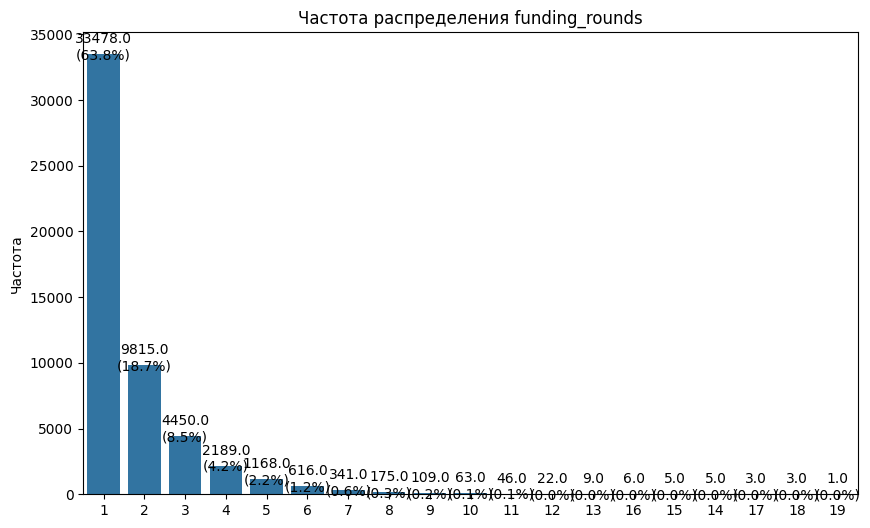

In [271]:
visualizer.plot_count_distribution(train, 'funding_rounds')

33478 стартапов имели 1 раунд финансирования (это около 64% от общего числа раудов, всего 19)

C:\Users\ksyub\AppData\Local\Temp\ipykernel_9736\1497539935.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


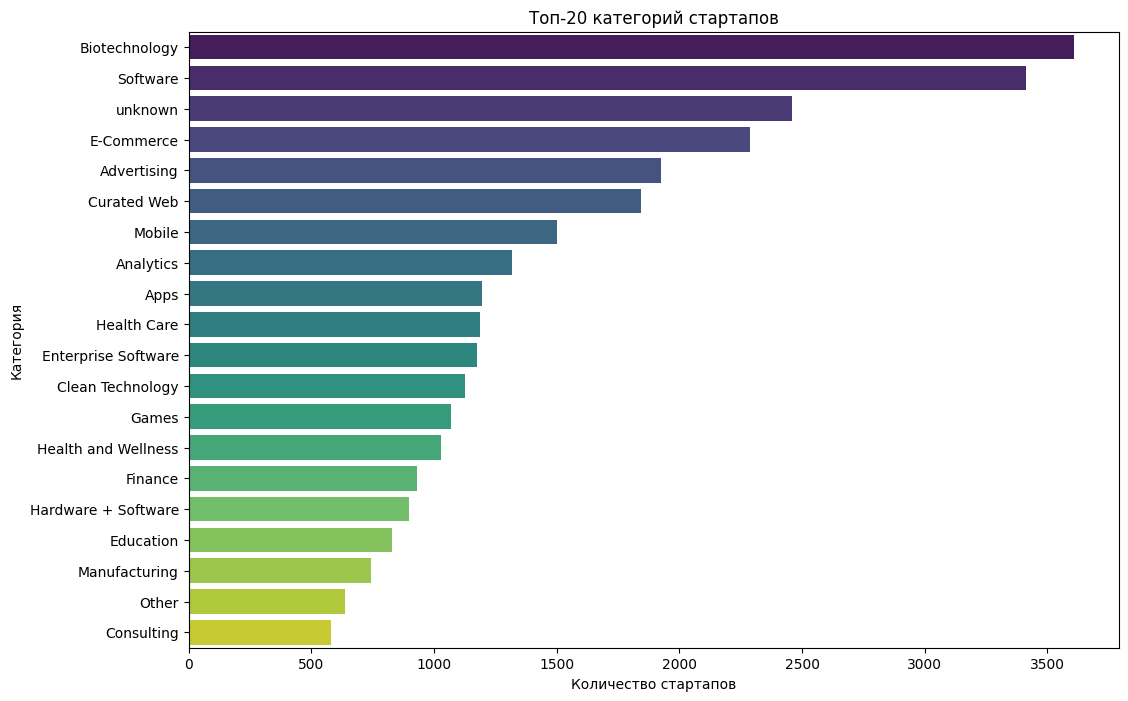

In [272]:
visualizer.plot_top_categories(train, 'category_group', top_n=20)

Больше всего категорий стартапов `Biotechnology` и `Software`.

### Двумерный анализ <a id='32'></a>

Использую библиотеку `phik` и построю тепловую карту признаков.

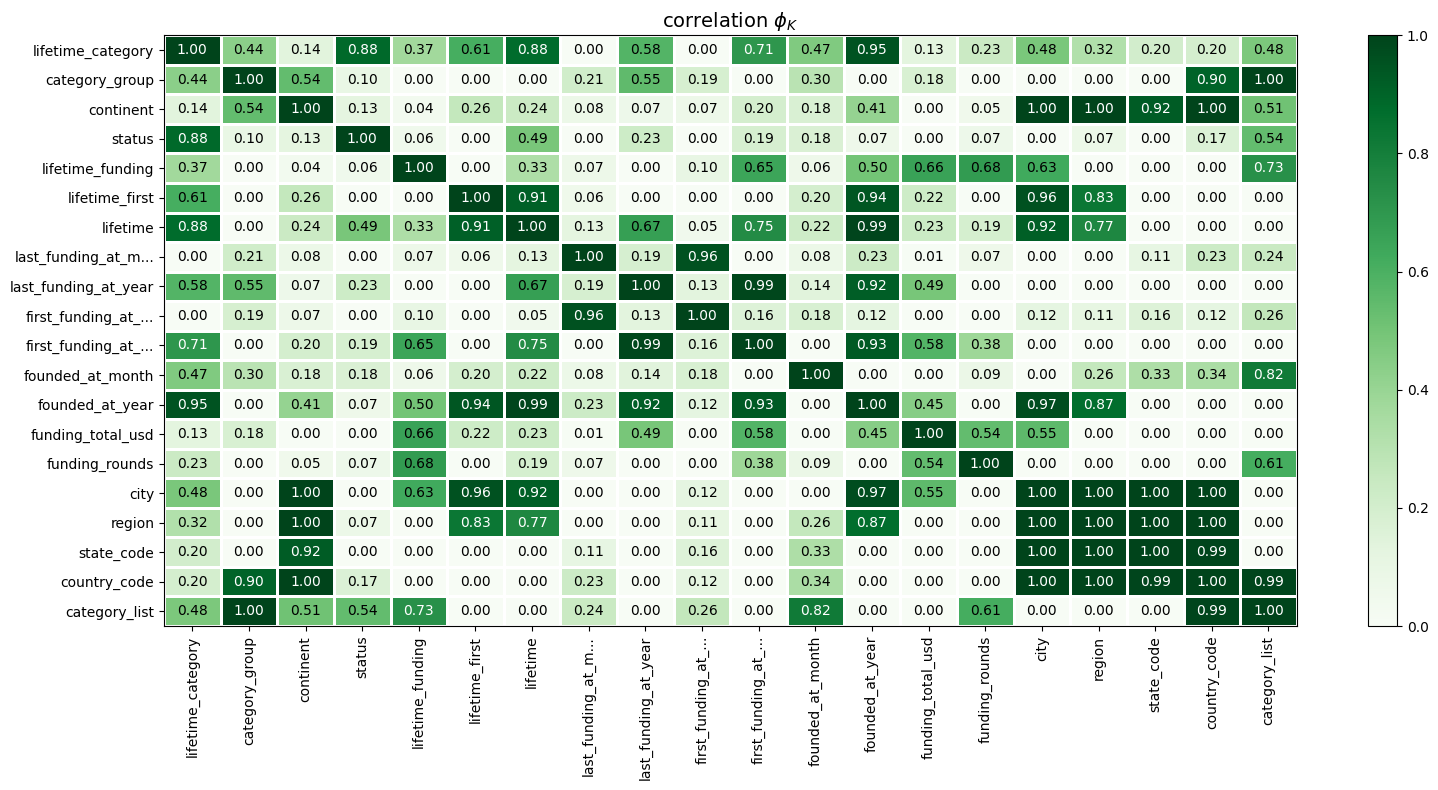

In [234]:
interval_cols = ['lifetime',
                 'funding_total_usd',
                 'lifetime_first',
                 'lifetime_funding']
corr_matrix = (train.drop(['latitude',
                           'founded_at',
                           'first_funding_at',
                           'last_funding_at',
                           'longitude', 'name'], axis=1)).sample(1000).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(corr_matrix.values, 
                        x_labels=corr_matrix.columns, 
                        y_labels=corr_matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(16, 8));
plt.tight_layout();

Итак, вижу корреляционную связь между многими признакми:
- вполне очевидно, что `continent` имеет корреляцию с геоданными (`country_code`, `state_code`, `region`, `city` между собой они также имеют сильную связь)
- `category_list` и `category_group` также имеют сильную связь.
- `lifetime_category` и `lifetime` также имеет связь с `founded_at_year`.
- признаки, которые содержат `lifetime` тоже имеют сильную связь.
- `status` имеет корреляцию с `lifetime_category`.

На этом этапе важно выбрать признаки для обучения модели. Возьму признаки `founded_at_month`, `last_funding_at_year`,
`lifetime`, `continent`, `category_group`, `lifetime_category`.

### Вывод <a id='33'></a>

**Одномерный анализ**

- У таргета присутствует диссбаланс (91% - operating, 9% - closed).
- Порядка 67% стартапов находяться в Северной Америки, 19% - в Европе, 11% - в Азии.
- Больше всего стартапов в США, Англии и Канаде, увы, Россия, к сожалению, не попала в топ 10 по странам. Что касается городов, то 10 лидеров:
    - San Francisco:     2824
    - New York:          2486
    - London:            1514
    - Austin:             609
    - Palo Alto:          605
    - Los Angeles:        604
    - Seattle:            592
    - Chicago:            546
    - Cambridge:          542
    - Boston:             508
- Большинство стартапов основаны в январе (23798). Больше всего было профинансированно в первый месяц (январь). Месяц окончания инвестирования аналогично
- Количество стартапов начало значительно увеличиваться с 2000 года, причем видно значительное снижение с 2013 по 2015 года. Если разделять по статусам, то заметно, что число закрытых стартапов начало увеличиваться с 2000 года, заметен небольшой скачок с 2006 года и с 2014.
-  Более "активно" начали инвестировать в стартапы с 2008 года, причем заметен спад с 2014 по 2015 года.
- Окончание инвестиционного раунда заметно увеличилось с 2007 по 2015 года.
- В среднем, сумма инвенстирования сотсавляет 7426479, а медианное значение в районе 2000000. 
- В среднем стартапы существуют 2557 дней.
- 33478 стартапов имели 1 раунд финансирования (это около 64% от общего числа раудов, всего 19)
- Больше всего категорий стартапов `Biotechnology` и `Software`.

**Двумерный анализ**

Вижу корреляционную связь между многими признакми:
- вполне очевидно, что `continent` имеет корреляцию с геоданными (`country_code`, `state_code`, `region`, `city` между собой они также имеют сильную связь)
- `category_list` и `category_group` также имеют сильную связь.
- `lifetime_category` и `lifetime` также имеет связь с `founded_at_year`.
- признаки, которые содержат `lifetime` тоже имеют сильную связь.
- `status` имеет корреляцию с `lifetime_category`.

На этом этапе важно выбрать признаки для обучения модели. Возьму признаки `founded_at_month`, `last_funding_at_year`,
`lifetime`, `continent`, `category_group`, `lifetime_category`.

## Обучение модели и предсказание статуса стартапа <a id='4'></a>

Для начала отберу признаки для обучения модели.

In [240]:
X = train.drop(['latitude',
                'category_list',
                  'funding_total_usd',
                  'country_code', 
                  'state_code',
                  'region',
                  'city',
                  'funding_rounds',
                  'founded_at',
                  'last_funding_at',
                  'first_funding_at',
                  'founded_at_year', #
                  #'founded_at_month',
                  'first_funding_at_year',
                  'first_funding_at_month', #
                  #'last_funding_at_year',
                  'last_funding_at_month',
                  #'lifetime',
                  #'continent',
                  #'category_group',
                  #'lifetime_category',
                   'longitude',
                   'status',
                   'lifetime_first',
                   'lifetime_funding',
                   'name'], axis=1).copy()
y = train['status'].copy()

Далее разобю датасет на тренировочные и валидационные.

In [242]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

### Обучение модели <a id='41'></a>
Использую библиотеку `optuna`, чтобы подобрать гипперпараметры для моделей. Передо мной стоит задача классификации, буду использовать модели `KNeighborsClassifier`, `DecisionTreeClassifier` и `CatBoostClassifier` оценивать буду с помощью метрики `F1`. Также из-за большого диссбаланса в таргете применю метод `SMOTE`.

In [245]:
def objective(trial):
    # Определение пространства поиска параметров для моделей
    model_type = trial.suggest_categorical('model_type', ['knn', 'dt', 'catboost'])

    if model_type == 'knn':
        n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif model_type == 'dt':
        max_depth = trial.suggest_int('max_depth', 2, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, 
                                       min_samples_split=min_samples_split, 
                                       min_samples_leaf=min_samples_leaf,
                                       random_state=RANDOM_STATE)
    elif model_type == 'catboost':
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
            'depth': trial.suggest_int('depth', 4, 10),
            'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10),
            'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),  # Исправление здесь
            'border_count': trial.suggest_int('border_count', 32, 255),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
            'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1e-2, 1e2),
            'thread_count': -1,
            'verbose': False,
            'random_state': RANDOM_STATE
        }
        model = CatBoostClassifier(**params)

    # Предобработка данных
    cat_columns = X.select_dtypes(exclude='number').columns.tolist()
    num_columns = X.select_dtypes(include='number').columns.tolist()

    ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ])

    num_pipe = Pipeline([
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    data_preprocessor = ColumnTransformer([
        ('ohe', ohe_pipe, cat_columns),
        ('num', num_pipe, num_columns)
    ], remainder='passthrough')

    # Создание пайплайна с SMOTE
    pipe = ImbPipeline([
        ('preprocessor', data_preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', model)
    ])

    # Оценка качества модели с кросс-валидацией
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    
    return np.mean(score)

In [246]:
# Создание экземпляра Study и запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Получение наилучших параметров и их значений
best_params = study.best_params
best_value = study.best_value

print("Best value:", best_value)
print("Best parameters:", best_params)

[I 2024-06-21 04:33:13,722] A new study created in memory with name: no-name-071d92d7-79e6-4b0a-8e76-39d0bd9fabed
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10),
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

[I 2024-06-21 04:42:09,543] Trial 9 finished with value: 0.9697979588344412 and parameters: {'model_type': 'catboost', 'iterations': 497, 'learning_rate': 0.007181540763575635, 'depth': 9, 'random_strength': 8.294241488475435e-06, 'bagging_temperature': 0.9945144306647518, 'border_count': 194, 'l2_leaf_reg': 0.7361458810555542, 'scale_pos_weight': 25.217254756947128}. Best is trial 4 with value: 0.9720919291918783.
[I 2024-06-21 04:42:54,694] Trial 10 finished with value: 0.8669457191320428 and parameters: {'model_type': 'knn', 'n_neighbors': 10}. Best is trial 4 with value: 0.9720919291918783.
[I 2024-06-21 04:43:03,814] Trial 11 finished with value: 0.9707426909076112 and parameters: {'model_type': 'dt', 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.9720919291918783.
[I 2024-06-21 04:43:13,078] Trial 12 finished with value: 0.9707031137373476 and parameters: {'model_type': 'dt', 'max_depth': 19, 'min_samples_split': 15, 'min_samples_l

[I 2024-06-21 04:58:21,751] Trial 30 finished with value: 0.9782473328259851 and parameters: {'model_type': 'catboost', 'iterations': 958, 'learning_rate': 0.09273214488876011, 'depth': 4, 'random_strength': 0.000679823182289251, 'bagging_temperature': 0.02057378121863862, 'border_count': 101, 'l2_leaf_reg': 0.03609863624473084, 'scale_pos_weight': 3.3104612501871045}. Best is trial 30 with value: 0.9782473328259851.
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

[I 2024-06-21 05:02:21,656] Trial 34 finished with value: 0.9784043449553191 and parameters: {'model_type': 'catboost', 'iterations': 997, 'learning_rate': 0.0867513812707579, 'depth': 4, 'random_strength': 0.000463539730231945, 'bagging_temperature': 0.008518792294239796, 'border_count': 107, 'l2_leaf_reg': 0.037257967037925284, 'scale_pos_weight': 2.8014285858787797}. Best is trial 32 with value: 0.9790843198516586.
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2024-06-21 05:06:23,617] Trial 38 finished with value: 0.9774904624331905 and parameters: {'model_type': 'catboost', 'iterations': 801, 'learning_rate': 0.08992271026488455, 'depth': 4, 'random_strength': 2.4485533099300067e-06, 'bagging_temperature': 0.20869948250196144, 'border_count': 73, 'l2_leaf_reg': 0.06457342636415095, 'scale_pos_weight': 0.8573925152876635}. Best is trial 35 with value: 0.9797024754734268.
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2024-06-21 05:10:37,213] Trial 42 finished with value: 0.9829087647213847 and parameters: {'model_type': 'catboost', 'iterations': 891, 'learning_rate': 0.09836169892379629, 'depth': 5, 'random_strength': 0.005952009823727908, 'bagging_temperature': 0.12424462591559297, 'border_count': 143, 'l2_leaf_reg': 0.019264460868357893, 'scale_pos_weight': 1.6559972104745904}. Best is trial 42 with value: 0.9829087647213847.
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2024-06-21 05:15:05,973] Trial 46 finished with value: 0.9744058593920105 and parameters: {'model_type': 'catboost', 'iterations': 903, 'learning_rate': 0.01302073461063226, 'depth': 5, 'random_strength': 6.85876796491269e-05, 'bagging_temperature': 0.32147694690281453, 'border_count': 139, 'l2_leaf_reg': 0.001162603148945461, 'scale_pos_weight': 1.4670941157839015}. Best is trial 43 with value: 0.9833162800067848.
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\ksyub\AppData\Local\Temp\ipykernel_16484\1944372351.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Best value: 0.9833162800067848
Best parameters: {'model_type': 'catboost', 'iterations': 882, 'learning_rate': 0.09779901843643836, 'depth': 5, 'random_strength': 0.00980194053005688, 'bagging_temperature': 0.13740597800173643, 'border_count': 146, 'l2_leaf_reg': 0.0010611206729585355, 'scale_pos_weight': 1.1672610317178158}


Лучше моделью окзалась `catboost` (0.98) с параметрами:
- 'iterations': 882, 
- 'learning_rate': 0.09779901843643836, 
- 'depth': 5, 
- 'random_strength': 0.00980194053005688, 
- 'bagging_temperature': 0.13740597800173643, 
- 'border_count': 146, 
- 'l2_leaf_reg': 0.0010611206729585355, 
- 'scale_pos_weight': 1.1672610317178158

In [253]:
# Определение preprocessor, если он еще не определен
cat_columns = X.select_dtypes(exclude='number').columns.tolist()
num_columns = X.select_dtypes(include='number').columns.tolist()

ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

# Использование найденных лучших параметров для обучения финальной модели
best_model_type = best_params['model_type']

if best_model_type == 'knn':
    best_model = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
elif best_model_type == 'dt':
    best_model = DecisionTreeClassifier(max_depth=best_params['max_depth'],
                                        min_samples_split=best_params['min_samples_split'],
                                        min_samples_leaf=best_params['min_samples_leaf'],
                                        random_state=RANDOM_STATE)
elif best_model_type == 'catboost':
    best_model = CatBoostClassifier(iterations=best_params['iterations'],
                                    depth=best_params['depth'],
                                    learning_rate=best_params['learning_rate'],
                                    random_strength=best_params['random_strength'],
                                    bagging_temperature=best_params['bagging_temperature'],
                                    border_count=best_params['border_count'],
                                    l2_leaf_reg=best_params['l2_leaf_reg'],
                                    scale_pos_weight=best_params['scale_pos_weight'],
                                    verbose=0,
                                    random_state=RANDOM_STATE)

# Полный пайплайн с наилучшими параметрами
best_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),  # добавляем SMOTE в пайплайн
    ('model', best_model)
])

# Обучение финальной модели с наилучшими параметрами
best_pipe.fit(X_train, y_train)

# Оценка качества на валидационной выборке
y_pred = best_pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

      closed       0.96      0.88      0.92      1229
   operating       0.99      1.00      0.99     11897

    accuracy                           0.99     13126
   macro avg       0.97      0.94      0.95     13126
weighted avg       0.98      0.99      0.98     13126



**Вывод**

- Высокая точность и полнота для класса `operating` (0.99 и 1.00) показывают, что модель почти всегда правильно предсказывает этот класс. Это логично, учитывая, что `support` для этого класса значительно выше (11897).
- Немного более низкая полнота для класса `closed` (0.88) указывает на то, что модель иногда ошибается, не распознавая этот класс. Однако, точность для этого класса высокая (0.96), что значит, что когда модель предсказывает `closed`, она почти всегда права.
- Высокие значения `F1-Score` для обоих классов (0.92 для closed и 0.99 для `operating`) показывают, что модель хорошо сбалансирована между точностью и полнотой.
- Высокие значения макро и взвешенного средних указывают на хорошую общую производительность модели, несмотря на дисбаланс классов.

В целом, модель демонстрирует отличные результаты, особенно в классе `operating`. Модель также достаточно хороша для класса `closed`, хотя есть небольшие возможности для улучшения полноты.

### Предсказание модели для тестовой выборки <a id='42'></a>

Также отберу анологичные признаки для тестовой модели.

In [256]:
X_test_df = test.drop(['latitude',
                'category_list',
                  'funding_total_usd',
                  'country_code', 
                  'state_code',
                  'region',
                  'city',
                  'funding_rounds',
                  'founded_at',
                  'last_funding_at',
                  'first_funding_at',
                  'founded_at_year', #
                  #'founded_at_month',
                  'first_funding_at_year',
                  'first_funding_at_month', #
                  #'last_funding_at_year',
                  'last_funding_at_month',
                  #'lifetime',
                  #'continent',
                  #'category_group',
                  #'lifetime_category',
                   'longitude',
                   'lifetime_first',
                   'lifetime_funding',
                   'name'], axis=1).copy()

Теперь сделаю предсказание статуса стартапа.

In [258]:
test['status'] = best_pipe.predict(X_test_df)

C:\Users\ksyub\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Сформирую submit, чтобы прогнать его на kaggle и получить метрику F1.

In [260]:
submit = test[['name','status']]
submit.to_csv('kaggle_submit_.csv', index= False)

В первых версиях моего исследования я не использовала модель `CatBoostClassifier`. Первичную метрика F1 у меня была 0.81, добавление катбуста она достигла 0.92.

### Выводы <a id='43'></a>

На данном этапе обучила модели  `KNeighborsClassifier`, `DecisionTreeClassifier` и `CatBoostClassifier` и оценила их метрикой `F1`.

Результаты на этапе обучения следующие:

- Высокая точность и полнота для класса `operating` (0.99 и 1.00) показывают, что модель почти всегда правильно предсказывает этот класс. Это логично, учитывая, что `support` для этого класса значительно выше (11897).
- Немного более низкая полнота для класса `closed` (0.88) указывает на то, что модель иногда ошибается, не распознавая этот класс. Однако, точность для этого класса высокая (0.96), что значит, что когда модель предсказывает `closed`, она почти всегда права.
- Высокие значения `F1-Score` для обоих классов (0.92 для closed и 0.99 для `operating`) показывают, что модель хорошо сбалансирована между точностью и полнотой.
- Высокие значения макро и взвешенного средних указывают на хорошую общую производительность модели, несмотря на дисбаланс классов.

Далее сформировала submit и загрузила результаты прогноза на Kaggle. Получила результат 0.92.

## Анализ важности признаков <a id='5'></a>

Использую SHAP для исследования важности признаков.

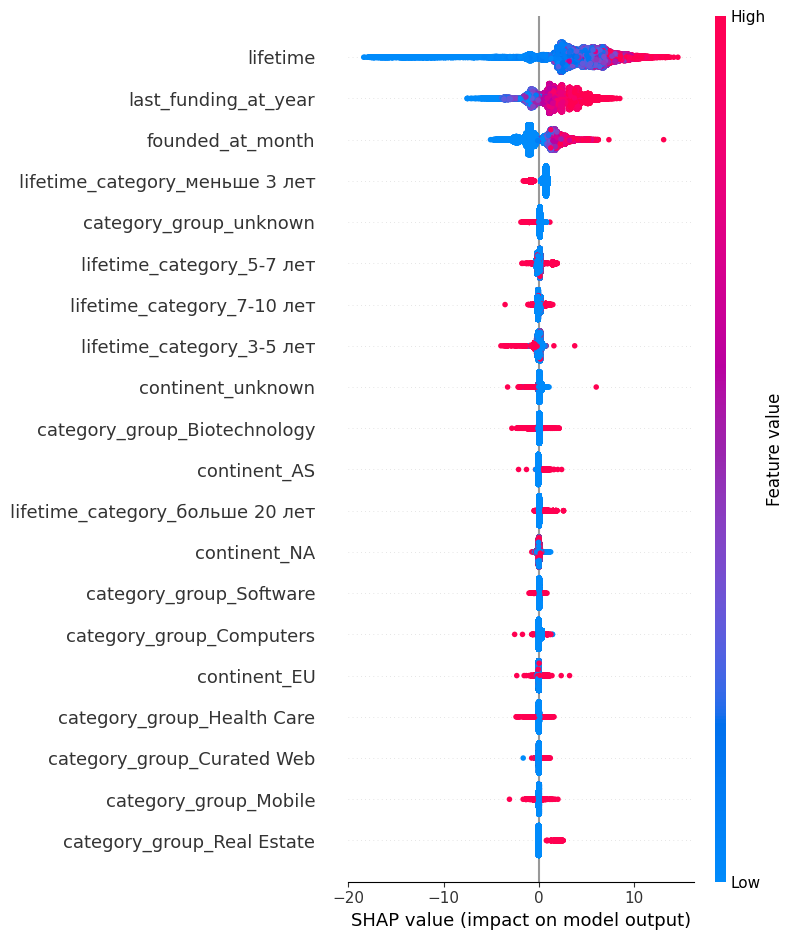

In [264]:
trained_model = best_pipe.named_steps['model']
X_train_processed = best_pipe.named_steps['preprocessor'].transform(X_train)
ohe_feature_names = best_pipe.named_steps['preprocessor'].named_transformers_['ohe']['ohe'].get_feature_names_out(cat_columns)
all_feature_names = np.concatenate([ohe_feature_names, num_columns])
explainer = shap.TreeExplainer(trained_model)
shap_values = explainer.shap_values(X_train_processed)
shap.summary_plot(shap_values, X_train_processed, feature_names=all_feature_names)

### Вывод

 Признаки, которые влияют больше на статус стартапа: `lifetime`, `last_funding_at_year`, `founded_at_month`.
 
 Возможно, стоит при следущей итерации проекта пересмотреть группировку данных.

## Итоговый вывод <a id='6'></a>

На входе передо мной стояла следущая цель: разработать модель для предсказания успешности стартапа (закроется или нет).
Были данны 2 датасета с тренировочными и тестовыми данными.

На выходе получила следущие результаты на каждом этапе:

1. Загрузка и ознакомление с данными

Датасет `train` содержит 52514 записей. Пропуски присутствуют в `name` (52513 записей),  `category_list` (50049 записей), `funding_total_usd` (42445 записей), `country_code` (47013 записей), `state_code` (45752 записей), `region` (46156 записей), `city` (46156 записей)- последние 2 столбца содержат одинаковое количество пропусков. Далее вижу, что опистельная статистика показывает минимальную сумму инвестирования стоставляет 1 $, что не очень выглядит правдоподобным, максимальная сумма также вызывает некоторые вопросы. Что касется самих данных стилистически названия столбцов выглядт верно. `category_list` содержит записи категорий, причем они состоят не только из основной категории, но и мультикатегорийных данных. `state_code` - состоит из числовых и буквенных обозначений (или состая из того и другого, например, GBR - C7), причем буквенные характерны только для США. Также в датасете есть столбцы с датами, приведем их в формат `datetime`. В тренировочном датасете отустствует `lifetime`, чтобы его добавить найду разницу между `founded_at` и `closed_at`, при этом в последнем столбце есть пропуски заменим их датой выгрузки датасета `2018-01-01`.
Аналогична ситуация и для датасета `test`. Пропуски присутствуют в анлогичных столбцах, что и в `train`.

2. Предобработка данных
    
На этапе предобработки данных сделала следующие:

1. Добавила новые признаки основннные на датах.
2. Убрала дубликаты из тренировочного датасета.
3. Предварительно ознакомилась с уникальными значениями категориальных признаков.
4. С помощью пайплайна заполнила пропуски.
5. Для тренировочного и тестового датасета добавила принадлежность к материку.
6. Укрупнила категории стартапов до 300.

3. Исследовательский анализ данных
    
**Одномерный анализ**

- У таргета присутствует диссбаланс (91% - operating, 9% - closed).
- Порядка 70% стартапов находяться в Северной Америки, 17% - в Европе, 10% - в Азии.
- Больше всего стартапов в США, Англии и Канаде, увы, Россия, к сожалению, не попала в топ 10 по странам. Что касается городов, то 10 лидеров:
    - San Francisco:     2824
    - New York:          2486
    - London:            1514
    - Austin:             609
    - Palo Alto:          605
    - Los Angeles:        604
    - Seattle:            592
    - Chicago:            546
    - Cambridge:          542
    - Boston:             508
- Большинство стартапов основаны в январе (23798). Больше всего было профинансированно в первый месяц (январь). Месяц окончания инвестирования аналогично
- Количество стартапов начало значительно увеличиваться с 2000 года, причем видно значительное снижение с 2013 по 2015 года. Если разделять по статусам, то заметно, что число закрытых стартапов начало увеличиваться с 2000 года, заметен небольшой скачок с 2006 года и с 2014.
-  Более "активно" начали инвестировать в стартапы с 2008 года, причем заметен спад с 2014 по 2015 года.
- Окончание инвестиционного раунда заметно увеличилось с 2007 по 2015 года.
- В среднем, сумма инвенстирования сотсавляет 7426479, а медианное значение в районе 2000000. 
- В среднем стартапы существуют 2557 дней.
- 33478 стартапов имели 1 раунд финансирования (это около 64% от общего числа раудов, всего 19)
- Больше всего категорий стартапов `Biotechnology` и `Software`.

**Двумерный анализ**

Вижу корреляционную связь между многими признакми:
- вполне очевидно, что `continent` имеет корреляцию с геоданными (`country_code`, `state_code`, `region`, `city` между собой они также имеют сильную связь)
- `category_list` и `category_group` также имеют сильную связь.
- `lifetime_category` и `lifetime` также имеет связь с `founded_at_year`.
- признаки, которые содержат `lifetime` тоже имеют сильную связь.
- `status` имеет корреляцию с `lifetime_category`.

На этом этапе важно выбрать признаки для обучения модели. Возьму признаки `founded_at_month`, `last_funding_at_year`,
`lifetime`, `continent`, `category_group`, `lifetime_category`.

4. Обучение модели и предсказание статуса стартапа
   
На данном этапе обучила модели  `KNeighborsClassifier`, `DecisionTreeClassifier` и `CatBoostClassifier` и оценила их метрикой `F1`.

Результаты на этапе обучения следующие:

- Высокая точность и полнота для класса `operating` (0.99 и 1.00) показывают, что модель почти всегда правильно предсказывает этот класс. Это логично, учитывая, что `support` для этого класса значительно выше (11897).
- Немного более низкая полнота для класса `closed` (0.88) указывает на то, что модель иногда ошибается, не распознавая этот класс. Однако, точность для этого класса высокая (0.96), что значит, что когда модель предсказывает `closed`, она почти всегда права.
- Высокие значения `F1-Score` для обоих классов (0.92 для closed и 0.99 для `operating`) показывают, что модель хорошо сбалансирована между точностью и полнотой.
- Высокие значения макро и взвешенного средних указывают на хорошую общую производительность модели, несмотря на дисбаланс классов.

Далее сформировала submit и загрузила результаты прогноза на Kaggle. Получила результат 0.92.

5. Анализ важности признаков

 Признаки, которые влияют больше на статус стартапа: `lifetime`, `last_funding_at_year`, `founded_at_month`.
 
 Возможно, стоит при следущей итерации проекта пересмотреть группировку данных.